# Beat The Freak

As the NBA regular season comes to a close, fans across the globe wait eagerly for some exciting playoff action (shoutout Dame Dolla). Coming off an insane MVP season last year, Giannis Antetokounpo and the Milwaukee Bucks yet again sit at the top of the Eastern Conference. With Giannis in the running for another MVP title, it's no secret that they will be a force to be reckoned with in the post-season. Before the sudden shutdown, the Bucks had a whopping 53-12 record, in which *Giannis only played in 9 of those losses*. 

It's obvious that Giannis is one of the most important factors to the Bucks' success, so what can you do to stop him? This project will focus on finding the strengths/weaknesses of the Bucks/Giannis, and what strategies could potentially be used to stop them.

## Part 1: Data Collection

For our data we will be using the [nba_api](https://github.com/swar/nba_api) kindly created by **@Swar Patel**. This project would have been impossible without his work!

Let's get all of the tables we'll need in one place so we don't have to keep calling the API whenever we need some data. 

In [1]:
# Import a lot of stuff
import pandas as pd
import numpy as np
import time

from scipy.stats import norm, gaussian_kde, percentileofscore, ttest_ind

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamvsplayer
from nba_api.stats.endpoints import leaguestandings
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.endpoints import teamestimatedmetrics
from nba_api.stats.endpoints import boxscoredefensive


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

### Giannis Career Stats

In [2]:
giannis_career_stats = playercareerstats.PlayerCareerStats(player_id = '203507').get_data_frames()[0]
giannis_career_stats

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,203507,2013-14,00,1610612749,MIL,19.0,77,23,1897.0,173,418,0.414,41,118,0.347,138,202,0.683,78,261,339,150,60,61,122,173,525
1,203507,2014-15,00,1610612749,MIL,20.0,81,71,2541.0,383,780,0.491,7,44,0.159,257,347,0.741,100,442,542,207,73,85,173,254,1030
2,203507,2015-16,00,1610612749,MIL,21.0,80,79,2823.0,513,1013,0.506,28,109,0.257,296,409,0.724,113,499,612,345,94,113,208,258,1350
3,203507,2016-17,00,1610612749,MIL,22.0,80,80,2845.0,656,1259,0.521,49,180,0.272,471,612,0.770,142,558,700,434,131,151,234,246,1832
4,203507,2017-18,00,1610612749,MIL,23.0,75,75,2756.0,742,1402,0.529,43,140,0.307,487,641,0.760,156,597,753,361,109,106,223,231,2014
5,203507,2018-19,00,1610612749,MIL,24.0,72,72,2358.0,721,1247,0.578,52,203,0.256,500,686,0.729,159,739,898,424,92,110,268,232,1994
6,203507,2019-20,00,1610612749,MIL,25.0,63,63,1917.0,685,1238,0.553,89,293,0.304,398,629,0.633,140,716,856,354,61,66,230,195,1857


### Giannis Per Game Stats

In [3]:
giannis_game_stats = playergamelog.PlayerGameLog(player_id = '203507').get_data_frames()[0]
giannis_game_stats

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,203507,0021901303,"AUG 11, 2020",MIL @ WAS,W,10,1,3,0.333,0,0,0.000,10,12,0.833,2,7,9,1,1,0,3,2,12,12,1
1,22019,203507,0021901284,"AUG 08, 2020",MIL @ DAL,L,33,13,26,0.500,1,7,0.143,7,14,0.500,2,11,13,1,0,5,4,6,34,-16,1
2,22019,203507,0021901269,"AUG 06, 2020",MIL vs. MIA,W,30,13,17,0.765,0,4,0.000,7,9,0.778,1,11,12,4,0,1,6,5,33,15,1
3,22019,203507,0021901256,"AUG 04, 2020",MIL vs. BKN,L,16,7,8,0.875,2,3,0.667,0,3,0.000,0,6,6,4,0,0,3,1,16,4,1
4,22019,203507,0021901248,"AUG 02, 2020",MIL @ HOU,L,33,14,25,0.560,2,5,0.400,6,9,0.667,4,14,18,8,0,1,3,3,36,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,22019,203507,0021900071,"NOV 01, 2019",MIL @ ORL,W,30,10,16,0.625,1,4,0.250,8,11,0.727,2,12,14,6,2,0,7,4,29,19,1
59,22019,203507,0021900058,"OCT 30, 2019",MIL @ BOS,L,35,8,13,0.615,0,2,0.000,6,10,0.600,1,13,14,5,1,2,3,4,22,-4,1
60,22019,203507,0021900046,"OCT 28, 2019",MIL vs. CLE,W,29,5,15,0.333,0,2,0.000,4,8,0.500,1,9,10,7,0,2,2,2,14,10,1
61,22019,203507,0021900026,"OCT 26, 2019",MIL vs. MIA,L,37,12,21,0.571,0,5,0.000,5,9,0.556,3,14,17,9,3,2,8,6,29,0,1


### Bucks' Game Stats 2019-2020

In [4]:
bucks_game_stats = teamgamelog.TeamGameLog(team_id = '1610612749').get_data_frames()[0]
bucks_game_stats

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612749,0021901311,"AUG 13, 2020",MIL @ MEM,L,56,17,0.767,240,39,98,0.398,13,41,0.317,15,23,0.652,9,36,45,27,8,3,15,22,106
1,1610612749,0021901303,"AUG 11, 2020",MIL @ WAS,W,56,16,0.778,240,44,87,0.506,18,38,0.474,20,28,0.714,9,44,53,25,6,0,14,26,126
2,1610612749,0021901294,"AUG 10, 2020",MIL vs. TOR,L,55,16,0.775,240,33,84,0.393,14,43,0.326,26,35,0.743,11,38,49,25,4,6,19,21,106
3,1610612749,0021901284,"AUG 08, 2020",MIL @ DAL,L,55,15,0.786,265,47,99,0.475,15,44,0.341,23,34,0.676,9,46,55,26,3,9,13,26,132
4,1610612749,0021901269,"AUG 06, 2020",MIL vs. MIA,W,55,14,0.797,240,41,78,0.526,15,37,0.405,33,38,0.868,5,39,44,27,7,3,14,21,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1610612749,0021900071,"NOV 01, 2019",MIL @ ORL,W,3,2,0.600,240,47,93,0.505,17,47,0.362,12,18,0.667,11,47,58,24,11,4,13,19,123
69,1610612749,0021900058,"OCT 30, 2019",MIL @ BOS,L,2,2,0.500,240,38,82,0.463,14,45,0.311,15,24,0.625,5,40,45,21,3,4,15,21,105
70,1610612749,0021900046,"OCT 28, 2019",MIL vs. CLE,W,2,1,0.667,240,48,92,0.522,17,38,0.447,16,24,0.667,8,42,50,29,9,7,12,15,129
71,1610612749,0021900026,"OCT 26, 2019",MIL vs. MIA,L,1,1,0.500,265,41,94,0.436,17,54,0.315,27,35,0.771,5,42,47,22,8,4,18,32,126


### Current League Standings 2019-2020

Use this to get **team_id**!

In [5]:
league_standings = leaguestandings.LeagueStandings(season = '2019-20').get_data_frames()[0]
league_standings

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,DivisionRecord,DivisionRank,WINS,LOSSES,WinPCT,LeagueRank,Record,HOME,ROAD,L10,Last10Home,Last10Road,OT,ThreePTSOrLess,TenPTSOrMore,LongHomeStreak,strLongHomeStreak,LongRoadStreak,strLongRoadStreak,LongWinStreak,LongLossStreak,CurrentHomeStreak,strCurrentHomeStreak,CurrentRoadStreak,strCurrentRoadStreak,CurrentStreak,strCurrentStreak,ConferenceGamesBack,DivisionGamesBack,ClinchedConferenceTitle,ClinchedDivisionTitle,ClinchedPlayoffBirth,EliminatedConference,EliminatedDivision,AheadAtHalf,BehindAtHalf,TiedAtHalf,AheadAtThird,BehindAtThird,TiedAtThird,Score100PTS,OppScore100PTS,OppOver500,LeadInFGPCT,LeadInReb,FewerTurnovers,PointsPG,OppPointsPG,DiffPointsPG,vsEast,vsAtlantic,vsCentral,vsSoutheast,vsWest,vsNorthwest,vsPacific,vsSouthwest,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS
0,00,22019,1610612747,Los Angeles,Lakers,West,36-10,1,- w,Pacific,10-3,1,52,19,0.732,0,52-19,25-10,27-9,4-6,7-3,6-4,2-0,7-3,25-11,6,W 6,14,W 14,10,4,-1,L 1,-2,L 2,-1,L 1,0.0,0.0,1,1,1,0,0,39-8,11-10,2-1,43-0,7-16,2-3,48-14,36-19,22-14,42-4,38-7,33-5,113.4,107.6,5.8,16-9,5-5,4-3,7-1,36-10,12-3,10-3,14-4,10-4,9-2,4-1,None,None,None,1-0,2-5,None,1-1,1-3,1-1,41-12,11-7
1,00,22019,1610612749,Milwaukee,Bucks,East,37-7,1,- e,Central,13-1,1,56,17,0.767,0,56-17,30-5,26-12,3-7,8-2,3-7,1-2,3-2,38-8,13,W 13,8,W 8,18,3,-1,L 1,-1,L 1,-1,L 1,0.0,0.0,1,1,1,0,0,46-4,10-12,0-1,49-2,5-15,2-0,55-15,40-17,20-13,54-5,46-4,20-5,118.7,108.6,10.1,37-7,10-4,13-1,14-2,19-10,7-3,7-2,5-5,11-2,10-1,2-4,None,None,None,1-0,2-5,None,1-0,1-3,1-2,46-8,10-9
2,00,22019,1610612746,LA,Clippers,West,32-16,2,- x,Pacific,8-6,2,49,23,0.681,0,49-23,27-9,22-14,6-4,6-4,7-3,2-1,8-3,32-8,10,W 10,4,W 4,7,3,1,W 1,3,W 3,2,W 2,3.5,3.5,0,0,1,0,0,36-6,13-14,0-3,38-4,9-19,2-0,47-18,32-23,22-13,40-5,36-3,22-5,116.3,109.9,6.4,17-7,5-3,4-3,8-1,32-16,11-5,8-6,13-5,9-4,7-4,4-1,None,None,None,0-1,5-2,None,1-1,2-1,2-1,37-18,12-5
3,00,22019,1610612761,Toronto,Raptors,East,34-11,2,- a,Atlantic,9-5,1,53,19,0.736,0,53-19,26-10,27-9,9-1,7-3,8-2,2-2,6-4,23-10,9,W 9,10,W 10,15,3,2,W 2,8,W 8,4,W 4,2.5,0.0,0,1,1,0,0,37-4,15-14,1-1,48-6,3-13,2-0,51-11,35-15,21-14,44-3,29-3,37-9,112.8,106.5,6.2,34-11,9-5,13-3,12-3,19-8,7-3,7-2,5-3,12-3,7-3,4-1,None,None,None,None,7-1,None,1-0,2-1,4-0,40-15,13-4
4,00,22019,1610612738,Boston,Celtics,East,30-13,3,- x,Atlantic,9-6,2,48,24,0.667,0,48-24,26-10,22-14,6-4,5-5,7-3,2-3,6-5,29-7,10,W 10,5,W 5,10,3,-1,L 1,2,W 2,-1,L 1,7.5,5.0,0,0,1,0,0,36-8,10-16,2-0,44-6,2-16,2-2,47-16,36-20,19-16,38-4,36-10,31-13,113.7,107.3,6.3,30-13,9-6,9-4,12-3,18-11,6-3,6-4,6-4,9-7,9-3,2-3,None,None,None,0-1,5-2,None,0-1,3-1,2-1,38-16,10-8
5,00,22019,1610612743,Denver,Nuggets,West,29-16,3,- nw,Northwest,12-2,1,46,27,0.630,0,46-27,26-11,20-16,4-6,5-5,4-6,5-3,9-5,16-13,5,W 5,4,W 4,7,3,-1,L 1,-2,L 2,-3,L 3,7.0,0.0,0,1,1,0,0,27-8,19-18,0-1,35-6,9-20,2-1,43-21,31-26,20-16,37-6,32-9,22-12,111.3,109.2,2.1,17-11,6-4,4-4,7-3,29-16,12-2,9-7,8-7,11-5,6-4,3-3,None,None,None,None,3-5,None,0-1,3-1,0-3,38-17,8-10
6,00,22019,1610612745,Houston,Rockets,West,28-19,4,- sw,Southwest,8-5,1,44,28,0.611,0,44-28,24-12,20-16,5-5,6-4,5-5,2-1,4-5,22-14,6,W 6,6,W 6,8,4,-2,L 2,-1,L 1,-3,L 3,8.5,0.0,0,1,1,0,0,32-8,10-19,2-1,38-6,6-22,0-0,44-23,40-28,19-13,25-3,20-6,26-14,117.8,114.8,3.0,16-9,6-3,4-3,6-3,28-19,10-8,10-6,8-5,7-7,9-2,1-4,None,None,None,1-0,3-4,None,1-0,2-1,1-3,34-20,10-8
7,00,22019,1610612754,Indiana,Pacers,East,28-19,4,- x,Central,8-7,2,45,28,0.616,0,45-28,25-11,20-17,7-3,7-3,6-4,3-1,5-7,20-12,6,W 6,4,W 4,5,6,4,W 4,1,W 1,2,W 2,11.0,11.0,0,0,1,0,0,33-5,12-21,0-2,36-5,6-22,3-1,45-17,33-26,14-18,37-11,25-3,27-15,109.4,107.5,2.0,28-19,9-7,8-7,11-5,17-9,7-3,5-2,5-4,9-5,5-7,3-2,None,None,None,None,6-2,None,1-0,3-1,2-1,32-23,13-5
8,00,22019,1610612748,Miami,Heat,East,30-13,5,- se,Southeast,10-4,1,44,29,0.603,0,44-29,29-7,15-22,4-6,6-4,3-7,8-1,6-4,23-11,11,W 11,-4,L 4,5,3,1,W 1,-3,L 3,-2,L 2,12.0,0.0,0,1,1,0,0,3

### Current League Roster 2019-2020

Use this to get **player_id**!

In [6]:
roster_lst = []

for team in league_standings.TeamID:
    team_roster = commonteamroster.CommonTeamRoster(team_id = team).get_data_frames()[0]
    roster_lst.append(team_roster)
    time.sleep(2)
    
league_roster = pd.concat(roster_lst)
league_roster

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612747,2019,00,Kyle Kuzma,kyle-kuzma,0,F,6-8,221,"JUL 24, 1995",24.0,2,Utah,1628398
1,1610612747,2019,00,Kentavious Caldwell-Pope,kentavious-caldwell-pope,1,G,6-5,204,"FEB 18, 1993",27.0,6,Georgia,203484
2,1610612747,2019,00,Anthony Davis,anthony-davis,3,F-C,6-10,253,"MAR 11, 1993",27.0,7,Kentucky,203076
3,1610612747,2019,00,Alex Caruso,alex-caruso,4,G,6-5,186,"FEB 28, 1994",26.0,2,Texas A&M,1627936
4,1610612747,2019,00,Talen Horton-Tucker,talen-horton-tucker,5,G,6-4,234,"NOV 25, 2000",19.0,R,Iowa State,1629659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,1610612744,2019,00,Andrew Wiggins,andrew-wiggins,22,F,6-7,197,"FEB 23, 1995",25.0,5,Kansas,203952
9,1610612744,2019,00,Draymond Green,draymond-green,23,F,6-6,230,"MAR 04, 1990",30.0,7,Michigan State,203110
10,1610612744,2019,00,Stephen Curry,stephen-curry,30,G,6-3,185,"MAR 14, 1988",32.0,10,Davidson,201939
11,1610612744,2019,00,Marquese Chriss,marquese-chriss,32,F,6-9,240,"JUL 02, 1997",22.0,3,Washington,1627737


### Current Team Stats 2019-2020

In [7]:
team_stats_lst = []

for team in league_standings.TeamID:
    team_stats = teamyearbyyearstats.TeamYearByYearStats(team_id = team).get_data_frames()[0][::-1].reset_index(drop = True).head(1)
    team_stats_lst.append(team_stats)
    time.sleep(2)

league_team_stats = pd.concat(team_stats_lst)
league_team_stats

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,CONF_COUNT,DIV_COUNT,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612747,Los Angeles,Lakers,2019-20,71,52,19,0.732,1,1,3,1,15.0,5,N/A,3006,6269,0.480,782,2242,0.349,1260,1728,0.729,757,2490,3247,1803,1471,612,1077,468,8054,16
0,1610612749,Milwaukee,Bucks,2019-20,73,56,17,0.767,1,1,4,1,15.0,5,N/A,3160,6638,0.476,1007,2840,0.355,1336,1800,0.742,691,3083,3774,1889,1431,526,1102,429,8663,2
0,1610612746,LA,Clippers,2019-20,72,49,23,0.681,2,2,3,2,15.0,5,N/A,2992,6425,0.466,895,2410,0.371,1498,1894,0.791,767,2664,3431,1708,1594,511,1051,338,8377,5
0,1610612761,Toronto,Raptors,2019-20,72,53,19,0.736,2,1,4,0,15.0,5,N/A,2897,6331,0.458,995,2663,0.374,1329,1670,0.796,685,2583,3268,1816,1559,636,1067,358,8118,13
0,1610612738,Boston,Celtics,2019-20,72,48,24,0.667,3,2,4,0,15.0,5,N/A,2971,6448,0.461,905,2487,0.364,1336,1668,0.801,768,2549,3317,1655,1553,595,995,406,8183,10
0,1610612743,Denver,Nuggets,2019-20,73,46,27,0.630,3,1,2,3,15.0,5,N/A,3069,6488,0.473,801,2234,0.359,1185,1526,0.777,786,2436,3222,1952,1485,586,1005,337,8124,12
0,1610612745,Houston,Rockets,2019-20,72,44,28,0.611,4,1,2,2,15.0,5,N/A,2936,6512,0.451,1126,3261,0.345,1484,1876,0.791,704,2484,3188,1557,1566,627,1057,371,8482,4
0,1610612754,Indiana,Pacers,2019-20,73,45,28,0.616,4,2,0,4,15.0,5,N/A,3075,6457,0.476,743,2046,0.363,1096,1393,0.787,636,2489,3125,1888,1445,543,967,376,7989,19
0,1610612748,Miami,Heat,2019-20,73,44,29,0.603,5,1,4,0,15.0,5,N/A,2880,6160,0.468,979,2584,0.379,1440,1840,0.783,620,2619,3239,1892,1501,547,1088,332,8179,11
0,1610612760,Oklahoma City,Thunder,2019-20,72,44,28,0.611,5,2,2,2,15.0,5,N/A,2879,6156,0.468,770,2171,0.355,1422,1787,0.796,593,2495,3088,1562,1390,550,986,353,7950,20


### Current Player Stats 2019-2020

In [8]:
league_stats_lst = []

for player in league_roster.PLAYER_ID:
    player_career_stats = playercareerstats.PlayerCareerStats(player_id = player).get_data_frames()[0]
    current_player_career_stats = player_career_stats[-1:]
    league_stats_lst.append(current_player_career_stats)
    time.sleep(2)

league_player_stats = pd.concat(league_stats_lst)
league_player_stats

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
2,1628398,2019-20,00,1610612747,LAL,24.0,61,9,1526.0,291,668,0.436,86,272,0.316,114,155,0.735,52,221,273,80,28,26,91,126,782
6,203484,2019-20,00,1610612747,LAL,27.0,69,26,1762.0,237,507,0.467,92,239,0.385,79,102,0.775,38,104,142,111,57,14,62,128,645
7,203076,2019-20,00,1610612747,LAL,27.0,62,62,2131.0,551,1096,0.503,72,218,0.330,444,525,0.846,142,435,577,200,91,143,154,156,1618
2,1627936,2019-20,00,1610612747,LAL,26.0,64,2,1175.0,120,291,0.412,40,120,0.333,69,94,0.734,17,106,123,124,70,18,53,98,349
0,1629659,2019-20,00,1610612747,LAL,19.0,6,1,81.0,14,30,0.467,4,13,0.308,2,4,0.500,2,5,7,6,8,1,6,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,203952,2019-20,00,0,TOT,25.0,54,54,1859.0,437,978,0.447,111,334,0.332,190,268,0.709,66,208,274,198,45,53,132,127,1175
7,203110,2019-20,00,1610612744,GSW,30.0,43,43,1222.0,123,316,0.389,36,129,0.279,63,83,0.759,23,243,266,266,59,33,98,110,345
10,201939,2019-20,00,1610612744,GSW,32.0,5,5,139.0,33,82,0.402,12,49,0.245,26,26,1.000,4,22,26,33,5,2,16,11,104
5,1627737,2019-20,00,1610612744,GSW,22.0,59,21,1196.0,210,385,0.545,8,39,0.205,120,156,0.769,114,251,365,114,39,62,78,122,548


### Combined Stats & Roster 2019-2020

Just combined the last two tables, to put all player information in one table.

In [9]:
combined_stats = pd.merge(league_roster, league_player_stats, on = ['PLAYER_ID', 'PLAYER_ID'])
combined_stats = combined_stats[combined_stats.SEASON_ID == '2019-20']
combined_stats

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612747,2019,00,Kyle Kuzma,kyle-kuzma,0,F,6-8,221,"JUL 24, 1995",24.0,2,Utah,1628398,2019-20,00,1610612747,LAL,24.0,61,9,1526.0,291,668,0.436,86,272,0.316,114,155,0.735,52,221,273,80,28,26,91,126,782
1,1610612747,2019,00,Kentavious Caldwell-Pope,kentavious-caldwell-pope,1,G,6-5,204,"FEB 18, 1993",27.0,6,Georgia,203484,2019-20,00,1610612747,LAL,27.0,69,26,1762.0,237,507,0.467,92,239,0.385,79,102,0.775,38,104,142,111,57,14,62,128,645
2,1610612747,2019,00,Anthony Davis,anthony-davis,3,F-C,6-10,253,"MAR 11, 1993",27.0,7,Kentucky,203076,2019-20,00,1610612747,LAL,27.0,62,62,2131.0,551,1096,0.503,72,218,0.330,444,525,0.846,142,435,577,200,91,143,154,156,1618
3,1610612747,2019,00,Alex Caruso,alex-caruso,4,G,6-5,186,"FEB 28, 1994",26.0,2,Texas A&M,1627936,2019-20,00,1610612747,LAL,26.0,64,2,1175.0,120,291,0.412,40,120,0.333,69,94,0.734,17,106,123,124,70,18,53,98,349
4,1610612747,2019,00,Talen Horton-Tucker,talen-horton-tucker,5,G,6-4,234,"NOV 25, 2000",19.0,R,Iowa State,1629659,2019-20,00,1610612747,LAL,19.0,6,1,81.0,14,30,0.467,4,13,0.308,2,4,0.500,2,5,7,6,8,1,6,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,1610612744,2019,00,Andrew Wiggins,andrew-wiggins,22,F,6-7,197,"FEB 23, 1995",25.0,5,Kansas,203952,2019-20,00,0,TOT,25.0,54,54,1859.0,437,978,0.447,111,334,0.332,190,268,0.709,66,208,274,198,45,53,132,127,1175
503,1610612744,2019,00,Draymond Green,draymond-green,23,F,6-6,230,"MAR 04, 1990",30.0,7,Michigan State,203110,2019-20,00,1610612744,GSW,30.0,43,43,1222.0,123,316,0.389,36,129,0.279,63,83,0.759,23,243,266,266,59,33,98,110,345
504,1610612744,2019,00,Stephen Curry,stephen-curry,30,G,6-3,185,"MAR 14, 1988",32.0,10,Davidson,201939,2019-20,00,1610612744,GSW,32.0,5,5,139.0,33,82,0.402,12,49,0.245,26,26,1.000,4,22,26,33,5,2,16,11,104
505,1610612744,2019,00,Marquese Chriss,marquese-chriss,32,F,6-9,240,"JUL 02, 1997",22.0,3,Washington,1627737,2019-20,00,1610612744,GSW,22.0,59,21,1196.0,210,385,0.545,8,39,0.205,120,156,0.769,114,251,365,114,39,62,78,122,548


## Part 2: EDA

Now that we've gathered all of the data we'll need for the project, we can start diving into the specifics of the data.

### What makes Giannis so good? 

I've watched one too many Youtube highlights of Giannis dunking from halfcourt (lol) to have a basic understanding of why he's so dominant. But what does the data have to say?

### 1) Giannis is putting up monster numbers!

In [10]:
forwards = combined_stats[combined_stats.POSITION == 'F']
top_forwards = forwards.sort_values(by = 'PTS', ascending = False).head(20).reset_index(drop = True)
top_forwards

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612749,2019,00,Giannis Antetokounmpo,giannis-antetokounmpo,34,F,6-11,242,"DEC 06, 1994",25.0,6,,203507,2019-20,00,1610612749,MIL,25.0,63,63,1917.0,685,1238,0.553,89,293,0.304,398,629,0.633,140,716,856,354,61,66,230,195,1857
1,1610612747,2019,00,LeBron James,lebron-james,23,F,6-9,250,"DEC 30, 1984",35.0,16,,2544,2019-20,00,1610612747,LAL,35.0,67,67,2316.0,643,1303,0.493,148,425,0.348,264,381,0.693,66,459,525,684,78,36,261,118,1698
2,1610612746,2019,00,Kawhi Leonard,kawhi-leonard,2,F,6-7,225,"JUN 29, 1991",29.0,8,San Diego State,202695,2019-20,00,1610612746,LAC,29.0,57,57,1848.0,532,1133,0.470,123,325,0.378,356,402,0.886,54,348,402,280,103,33,149,113,1543
3,1610612740,2019,00,Brandon Ingram,brandon-ingram,14,F,6-7,190,"SEP 02, 1997",22.0,3,Duke,1627742,2019-20,00,1610612740,NOP,22.0,62,62,2103.0,507,1096,0.463,150,384,0.391,313,368,0.851,51,329,380,259,61,38,189,179,1477
4,1610612755,2019,00,Tobias Harris,tobias-harris,12,F,6-8,226,"JUL 15, 1992",27.0,8,Tennessee,202699,2019-20,00,1610612755,PHI,27.0,72,72,2469.0,553,1173,0.471,131,357,0.367,174,216,0.806,69,426,495,227,53,40,104,165,1411
5,1610612761,2019,00,Pascal Siakam,pascal-siakam,43,F,6-9,230,"APR 02, 1994",26.0,3,New Mexico State,1627783,2019-20,00,1610612761,TOR,26.0,60,60,2110.0,500,1104,0.453,131,365,0.359,240,303,0.792,64,375,439,207,61,53,148,170,1371
6,1610612754,2019,00,T.J. Warren,tj-warren,1,F,6-8,220,"SEP 05, 1993",26.0,5,North Carolina State,203933,2019-20,00,1610612754,IND,26.0,67,67,2202.0,534,997,0.536,91,226,0.403,167,204,0.819,68,212,280,99,78,34,84,187,1326
7,1610612749,2019,00,Khris Middleton,khris-middleton,22,F,6-7,222,"AUG 12, 1991",28.0,7,Texas A&M,203114,2019-20,00,1610612749,MIL,28.0,62,59,1853.0,471,947,0.497,147,354,0.415,208,227,0.916,44,338,382,265,53,7,137,142,1297
8,1610612762,2019,00,Bojan Bogdanovic,bojan-bogdanovic,44,F,6-8,226,"APR 18, 1989",31.0,5,,202711,2019-20,00,1610612762,UTA,31.0,63,63,2083.0,418,935,0.447,189,457,0.414,250,277,0.903,39,220,259,131,34,7,159,110,1275
9,1610612744,2019,00,Andrew Wiggins,andrew-wiggins,22,F,6-7,197,"FEB 23, 1995",25.0,5,Kansas,203952,2019-20,00,0,TOT,25.0,54,54,1859.0,437,978,0.447,111,334,0.332,190,268,0.709,66,208,274,198,45,53,132,127,1175


Text(1550, 420, 'Kawhi')

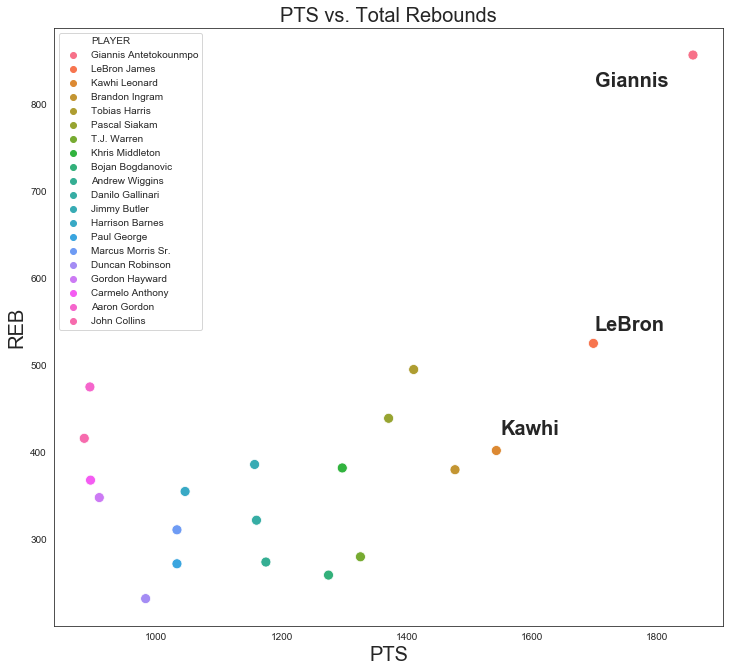

In [11]:
plt.rcParams['figure.figsize'] = (12,11)
ax = sns.scatterplot(x = top_forwards.PTS, y = top_forwards.REB, hue = top_forwards.PLAYER, s = 100)
ax.set_title('PTS vs. Total Rebounds', fontsize = 20)
ax.set_xlabel('PTS', fontsize = 20)
ax.set_ylabel('REB', fontsize = 20)
ax.annotate('Giannis', xy = (1700, 820), fontsize = 20, weight = 'bold')
ax.annotate('LeBron', xy = (1700, 540), fontsize = 20, weight = 'bold')
ax.annotate('Kawhi', xy = (1550, 420), fontsize = 20, weight = 'bold')

From this we can visually see the difference between him and the other great Forwards in the league. Even compared to the likes of LeBron, **Giannis is putting up the best numbers for his position** (*also is #4 overall in scoring across all positions*)

### 2 ) He has teammates that can spread the floor!

I think a lot of Giannis' success in the league can and should be acredited to his teammates. Although he doesn't have a Steph Curry in his back pocket, Giannis definitely has some three-point assasains that allow him to use his length and athleticism down low. What does the data say?

In [12]:
bucks_starters = ['Khris Middleton', 'Brook Lopez', 'Wesley Matthews', 'Eric Bledsoe', 'Giannis Antetokounmpo']
bucks_starters_stats = combined_stats[combined_stats['PLAYER'].isin(bucks_starters)].reset_index(drop = True)
bucks_starters_stats

,TeamID,SEASON,LeagueID,PLAYER,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612749,2019,00,Eric Bledsoe,eric-bledsoe,6,G,6-1,214,"DEC 09, 1989",30.0,9,Kentucky,202339,2019-20,00,1610612749,MIL,30.0,61,61,1646.0,334,703,0.475,74,215,0.344,169,214,0.790,43,239,282,328,57,26,148,128,911
1,1610612749,2019,00,Wesley Matthews,wesley-matthews,9,G,6-4,220,"OCT 14, 1986",33.0,10,Marquette,202083,2019-20,00,1610612749,MIL,33.0,67,67,1635.0,167,422,0.396,108,297,0.364,52,68,0.765,22,144,166,92,38,9,43,103,494
2,1610612749,2019,00,Brook Lopez,brook-lopez,11,C,7-0,282,"APR 01, 1988",32.0,11,Stanford,201572,2019-20,00,1610612749,MIL,32.0,68,67,1817.0,292,671,0.435,102,325,0.314,127,152,0.836,58,254,312,99,46,163,70,163,813
3,1610612749,2019,00,Khris Middleton,khris-middleton,22,F,6-7,222,"AUG 12, 1991",28.0,7,Texas A&M,203114,2019-20,00,1610612749,MIL,28.0,62,59,1853.0,471,947,0.497,147,354,0.415,208,227,0.916,44,338,382,265,53,7,137,142,1297
4,1610612749,2019,00,Giannis Antetokounmpo,giannis-antetokounmpo,34,F,6-11,242,"DEC 06, 1994",25.0,6,,203507,2019-20,00,1610612749,MIL,25.0,63,63,1917.0,685,1238,0.553,89,293,0.304,398,629,0.633,140,716,856,354,61,66,230,195,1857


In [13]:
bucks_starters_stats.FG3_PCT[0:4]

0    0.344
1    0.364
2    0.314
3    0.415
Name: FG3_PCT, dtype: float64

In [14]:
combined_stats[combined_stats.FG3_PCT != 0].FG3_PCT.mean()

0.3383544018058692

Here we can see that the Bucks starters are (except barely Eric Bledsoe) have above average 3PT shooters. In particular, the Bucks have an Allstar shooting guard, Khris Middleton, who's shooting at a whopping 41% this season. How can we better visualize this result?

In [15]:
def get_player_shotchart(player_name, season_id):
    '''
    player_name: name of player with Capital
    season_id: ex. 2019-20
    '''
    
    team_id = league_roster[league_roster.PLAYER == player_name].reset_index(drop = True).TeamID[0]
    player_id = league_roster[league_roster.PLAYER == player_name].reset_index(drop = True).PLAYER_ID[0]
    
    shotchartlist = shotchartdetail.ShotChartDetail(team_id = int(team_id),
                                               player_id = int(player_id),
                                               season_type_all_star = 'Regular Season',
                                               season_nullable = season_id,
                                               context_measure_simple = 'FGA').get_data_frames()
    shotchart_df = shotchartlist[0]
    return shotchart_df

In [16]:
giannis_shots = get_player_shotchart('Giannis Antetokounmpo', '2019-20')
giannis_shots

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900015,46,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,9,17,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,25,253,1,0,20191024,HOU,MIL
1,Shot Chart Detail,0021900015,64,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,7,54,Missed Shot,Driving Floating Bank Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,25,6,1,0,20191024,HOU,MIL
2,Shot Chart Detail,0021900015,193,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,0,35,Made Shot,Turnaround Fadeaway shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,3,47,1,1,20191024,HOU,MIL
3,Shot Chart Detail,0021900015,219,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,2,11,5,Made Shot,Turnaround Fadeaway Bank Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,-22,38,1,1,20191024,HOU,MIL
4,Shot Chart Detail,0021900015,222,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,2,10,39,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,20,20,199,1,1,20191024,HOU,MIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,Shot Chart Detail,0021901284,840,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,5,0,31,Made Shot,Running Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,8,1,1,20200808,DAL,MIL
1234,Shot Chart Detail,0021901284,851,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,5,0,5,Made Shot,Cutting Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-5,4,1,1,20200808,DAL,MIL
1235,Shot Chart Detail,0021901303,22,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,11,9,Made Shot,Running Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-6,25,1,1,20200811,WAS,MIL
1236,Shot Chart Detail,0021901303,25,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,10,44,Missed Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,16,4,165,1,0,20200811,WAS,MIL


In [17]:
def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False):
    """Returns an axes with a basketball court drawn onto to it.
    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example the center of the
    hoop is located at the (0,0) coordinate.  Twenty-two feet from the left of
    the center of the hoop in is represented by the (-220,0) coordinates.
    So one foot equals +/-10 units on the x and y-axis.
    Parameters
    ----------
    ax : Axes, optional
        The Axes object to plot the court onto.
    color : matplotlib color, optional
        The color of the court lines.
    lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If `True` it draws the out of bound lines in same style as the rest of
        the court.
    Returns
    -------
    ax : Axes
        The Axes object with the court on it.
    """
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # Draw shotzone Lines
    # Based on Advanced Zone Mode
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='black', fill=False)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='black', fill=False)
        corner_three_a_x =  Rectangle((-250, 92.5), 30, 0, linewidth=lw, color=color)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color=color)
        
        # 60 degrees
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color=color)
        # 120 degrees
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color=color)
        
        # Assume x distance is also 40 for the endpoint
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color=color)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color=color)
        
        # Assume y distance is also 92.5 for the endpoint
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color=color)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color=color)
        
        
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x,
                          inner_line_1, inner_line_2, inner_line_3, inner_line_4, inner_line_5, inner_line_6]
    else:
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

In [18]:
def heatmap(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)
    
    x = data['LOC_X']
    y = data['LOC_Y']
    
    sns.kdeplot(x, y, shade=True, cmap='inferno', ax=ax, **kwargs)

    ax.scatter(x, y, facecolors='w', s=2, linewidths=0.1, **kwargs)
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

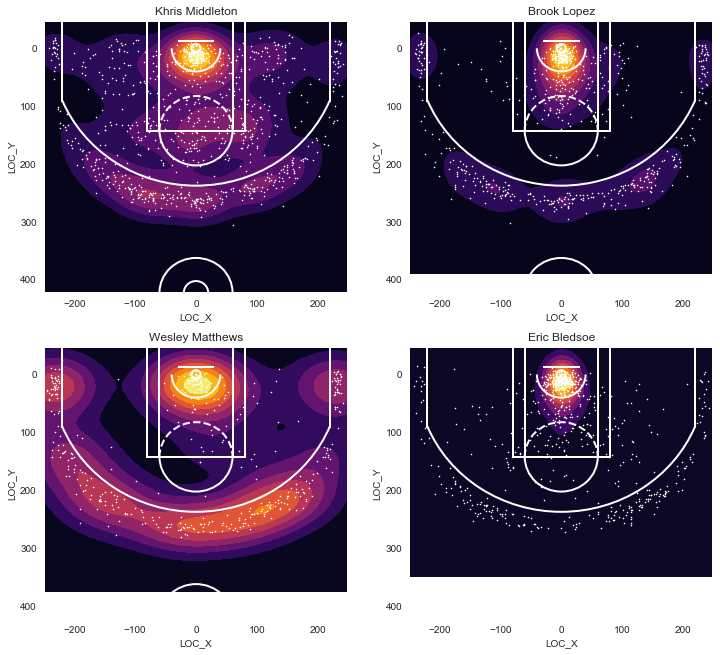

In [19]:
for i in range(0,4):
    plt.subplot(2,2,i+1)
    name = bucks_starters[i]
    player_shots = get_player_shotchart(name, '2019-20')
    heatmap(player_shots)
    plt.title(name)

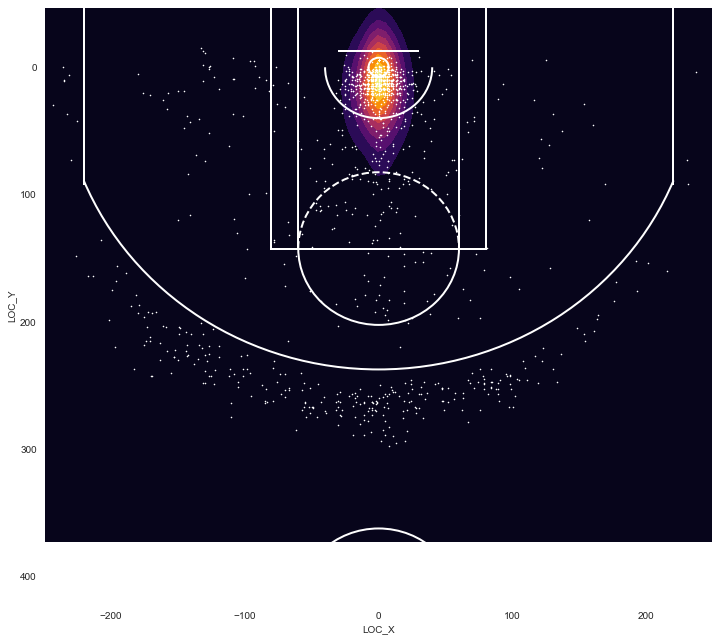

In [20]:
heatmap(giannis_shots)

Here we have created a heatmap of the shots that the Bucks' starters took this regular season! From this we can see the frequency and location at which each player takes a shot. 

This gives us a better look at the dilemma that teams have to decide on a play-by-play basis. Since it's clear that Giannis is a beast in the paint, **should teams risk double teaming Giannis down low and risk giving up an open three beyond the arc**?

### Winning Teams

Which teams have defeated Giannis and the Bucks in the regular season? Do they have any similar qualities compared to those who haven't?

In [21]:
bucks_losing_games = bucks_game_stats[bucks_game_stats['WL'] == 'L'].reset_index(drop = True)
bucks_losing_games

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612749,0021901311,"AUG 13, 2020",MIL @ MEM,L,56,17,0.767,240,39,98,0.398,13,41,0.317,15,23,0.652,9,36,45,27,8,3,15,22,106
1,1610612749,0021901294,"AUG 10, 2020",MIL vs. TOR,L,55,16,0.775,240,33,84,0.393,14,43,0.326,26,35,0.743,11,38,49,25,4,6,19,21,106
2,1610612749,0021901284,"AUG 08, 2020",MIL @ DAL,L,55,15,0.786,265,47,99,0.475,15,44,0.341,23,34,0.676,9,46,55,26,3,9,13,26,132
3,1610612749,0021901256,"AUG 04, 2020",MIL vs. BKN,L,54,14,0.794,240,42,88,0.477,17,51,0.333,15,23,0.652,7,47,54,28,3,5,18,19,116
4,1610612749,0021901248,"AUG 02, 2020",MIL @ HOU,L,54,13,0.806,240,45,92,0.489,9,35,0.257,17,23,0.739,17,48,65,21,6,6,22,23,116
5,1610612749,0021900958,"MAR 09, 2020",MIL @ DEN,L,53,12,0.815,240,34,90,0.378,15,50,0.300,12,18,0.667,11,37,48,23,8,4,17,15,95
6,1610612749,0021900950,"MAR 08, 2020",MIL @ PHX,L,53,11,0.828,240,51,95,0.537,13,33,0.394,16,21,0.762,7,29,36,23,7,3,10,29,131
7,1610612749,0021900939,"MAR 06, 2020",MIL @ LAL,L,53,10,0.841,240,37,89,0.416,12,43,0.279,17,23,0.739,5,40,45,22,8,1,19,32,103
8,1610612749,0021900906,"MAR 02, 2020",MIL @ MIA,L,52,9,0.852,240,35,86,0.407,7,34,0.206,12,19,0.632,8,40,48,19,4,5,13,18,89
9,1610612749,0021900810,"FEB 12, 2020",MIL @ IND,L,46,8,0.852,240,37,91,0.407,13,37,0.351,24,25,0.960,11,33,44,18,7,5,17,21,111


Although we've determined that the Bucks lost, this **does not guarantee that Giannis played in all 17 of these losses**. We need to filter out the games that Giannis did *not* play in.

In [22]:
# Imagine venn-diagram of all of Giannis' losses and all of Bucks' games
giannis_losing_game_ids = list(set(giannis_shots.GAME_ID).intersection(bucks_losing_games.Game_ID))
giannis_losing_games = bucks_losing_games[bucks_losing_games.Game_ID.isin(giannis_losing_game_ids)].reset_index(drop = True)
giannis_losing_games

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612749,0021901284,"AUG 08, 2020",MIL @ DAL,L,55,15,0.786,265,47,99,0.475,15,44,0.341,23,34,0.676,9,46,55,26,3,9,13,26,132
1,1610612749,0021901256,"AUG 04, 2020",MIL vs. BKN,L,54,14,0.794,240,42,88,0.477,17,51,0.333,15,23,0.652,7,47,54,28,3,5,18,19,116
2,1610612749,0021901248,"AUG 02, 2020",MIL @ HOU,L,54,13,0.806,240,45,92,0.489,9,35,0.257,17,23,0.739,17,48,65,21,6,6,22,23,116
3,1610612749,0021900939,"MAR 06, 2020",MIL @ LAL,L,53,10,0.841,240,37,89,0.416,12,43,0.279,17,23,0.739,5,40,45,22,8,1,19,32,103
4,1610612749,0021900906,"MAR 02, 2020",MIL @ MIA,L,52,9,0.852,240,35,86,0.407,7,34,0.206,12,19,0.632,8,40,48,19,4,5,13,18,89
5,1610612749,0021900724,"JAN 31, 2020",MIL vs. DEN,L,41,7,0.854,240,43,95,0.453,12,40,0.300,17,26,0.654,7,39,46,29,7,5,13,14,115
6,1610612749,0021900546,"JAN 06, 2020",MIL @ SAS,L,32,6,0.842,240,38,95,0.400,15,45,0.333,13,14,0.929,10,28,38,24,5,5,8,15,104
7,1610612749,0021900456,"DEC 25, 2019",MIL @ PHI,L,27,5,0.844,240,45,95,0.474,13,33,0.394,6,8,0.750,8,39,47,23,6,6,10,15,109
8,1610612749,0021900398,"DEC 16, 2019",MIL vs. DAL,L,24,4,0.857,240,44,105,0.419,11,41,0.268,17,24,0.708,15,37,52,29,8,4,8,23,116
9,1610612749,0021900124,"NOV 08, 2019",MIL @ UTA,L,6,3,0.667,240,34,95,0.358,10,36,0.278,22,30,0.733,16,38,54,14,8,4,12,26,100


As expected, **Giannis was not in every game that the Bucks lost this regular season - he was in 12 of them (~70%).**

Let's now take a closer look at the teams that have been successful against Giannis.

In [23]:
winners = ['Mavericks', 'Nets', 'Rockets', 'Lakers', 'Heat',
           'Nuggets', 'Spurs', '76ers', 'Jazz', 'Celtics']

winners_team_stats = league_team_stats[league_team_stats.TEAM_NAME.isin(winners)].reset_index(drop = True)
winners_team_stats

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,CONF_COUNT,DIV_COUNT,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612747,Los Angeles,Lakers,2019-20,71,52,19,0.732,1,1,3,1,15.0,5,N/A,3006,6269,0.480,782,2242,0.349,1260,1728,0.729,757,2490,3247,1803,1471,612,1077,468,8054,16
1,1610612738,Boston,Celtics,2019-20,72,48,24,0.667,3,2,4,0,15.0,5,N/A,2971,6448,0.461,905,2487,0.364,1336,1668,0.801,768,2549,3317,1655,1553,595,995,406,8183,10
2,1610612743,Denver,Nuggets,2019-20,73,46,27,0.630,3,1,2,3,15.0,5,N/A,3069,6488,0.473,801,2234,0.359,1185,1526,0.777,786,2436,3222,1952,1485,586,1005,337,8124,12
3,1610612745,Houston,Rockets,2019-20,72,44,28,0.611,4,1,2,2,15.0,5,N/A,2936,6512,0.451,1126,3261,0.345,1484,1876,0.791,704,2484,3188,1557,1566,627,1057,371,8482,4
4,1610612748,Miami,Heat,2019-20,73,44,29,0.603,5,1,4,0,15.0,5,N/A,2880,6160,0.468,979,2584,0.379,1440,1840,0.783,620,2619,3239,1892,1501,547,1088,332,8179,11
5,1610612755,Philadelphia,76ers,2019-20,73,43,30,0.589,6,3,0,4,15.0,5,N/A,3000,6417,0.468,848,2307,0.368,1236,1638,0.755,764,2553,3317,1884,1529,586,1037,389,8084,15
6,1610612762,Utah,Jazz,2019-20,72,44,28,0.611,6,3,3,2,15.0,5,N/A,2886,6130,0.471,963,2537,0.380,1278,1641,0.779,656,2577,3233,1615,1468,438,1089,292,8013,18
7,1610612742,Dallas,Mavericks,2019-20,75,43,32,0.573,7,2,2,3,15.0,5,N/A,3124,6772,0.461,1136,3095,0.367,1392,1787,0.779,791,2729,3520,1849,1462,460,953,363,8776,1
8,1610612751,Brooklyn,Nets,2019-20,72,35,37,0.486,7,4,0,4,15.0,5,N/A,2908,6498,0.448,941,2746,0.343,1291,1732,0.745,766,2683,3449,1761,1510,464,1099,323,8048,17
9,1610612759,San Antonio,Spurs,2019-20,71,32,39,0.451,11,4,0,0,15.0,5,N/A,2995,6350,0.472,760,2021,0.376,1348,1664,0.810,640,2530,3170,1751,1377,518,895,390,8098,14


In [24]:
print('Average Winning Teams Stats')
print('- - - - - - - - - - - - - - ')
for i in range(15,33):
    print(winners_team_stats.columns[i], ':', winners_team_stats.iloc[:,i].mean())

Average Winning Teams Stats
- - - - - - - - - - - - - - 
FGM : 2977.5
FGA : 6404.4
FG_PCT : 0.46530000000000005
FG3M : 924.1
FG3A : 2551.4
FG3_PCT : 0.363
FTM : 1325.0
FTA : 1710.0
FT_PCT : 0.7749
OREB : 725.2
DREB : 2565.0
REB : 3290.2
AST : 1771.9
PF : 1492.2
STL : 543.3
TOV : 1029.5
BLK : 367.1
PTS : 8204.1


*How do these winners compare in stats to the losing teams?*

In [25]:
losers_team_stats = league_team_stats[~league_team_stats.TEAM_NAME.isin(winners)].reset_index(drop = True)
losers_team_stats = losers_team_stats[~(losers_team_stats.TEAM_NAME == 'Bucks')]

print('Average Losing Teams Stats')
print('- - - - - - - - - - - - - - ')
for i in range(15,33):
    print(losers_team_stats.columns[i], ':', losers_team_stats.iloc[:,i].mean())

Average Losing Teams Stats
- - - - - - - - - - - - - - 
FGM : 2821.842105263158
FGA : 6180.736842105263
FG_PCT : 0.45621052631578946
FG3M : 821.7894736842105
FG3A : 2310.4210526315787
FG3_PCT : 0.3551578947368421
FTM : 1223.157894736842
FTA : 1581.2105263157894
FT_PCT : 0.772421052631579
OREB : 705.1052631578947
DREB : 2362.315789473684
REB : 3067.4210526315787
AST : 1686.3684210526317
PF : 1455.3157894736842
STL : 539.0
TOV : 1021.3157894736842
BLK : 330.42105263157896
PTS : 7688.631578947368


There doesn't appear to be any significant difference in overall team stats with the winning and losing teams. Should we run a hypothesis test?

In [26]:
for i in range(15,33):
    ttest = ttest_ind(losers_team_stats.iloc[:,i], winners_team_stats.iloc[:,i])
    p_val = ttest[1]
    print(losers_team_stats.columns[i])
    if p_val < 0.05:
        print('Significant Difference!')
        print(p_val)
    else:
        print('No Significant Difference')
    print('- - - - - - - - - - -')

FGM
Significant Difference!
0.045587423149199995
- - - - - - - - - - -
FGA
No Significant Difference
- - - - - - - - - - -
FG_PCT
Significant Difference!
0.04815626488689487
- - - - - - - - - - -
FG3M
Significant Difference!
0.024734064201731753
- - - - - - - - - - -
FG3A
Significant Difference!
0.041185283005726374
- - - - - - - - - - -
FG3_PCT
No Significant Difference
- - - - - - - - - - -
FTM
No Significant Difference
- - - - - - - - - - -
FTA
Significant Difference!
0.03142551598856776
- - - - - - - - - - -
FT_PCT
No Significant Difference
- - - - - - - - - - -
OREB
No Significant Difference
- - - - - - - - - - -
DREB
Significant Difference!
0.006791117969174707
- - - - - - - - - - -
REB
Significant Difference!
0.00862516842317194
- - - - - - - - - - -
AST
No Significant Difference
- - - - - - - - - - -
PF
No Significant Difference
- - - - - - - - - - -
STL
No Significant Difference
- - - - - - - - - - -
TOV
No Significant Difference
- - - - - - - - - - -
BLK
No Significant Differ

There are a quite few different stats that seem to be different for both groups: **FGM, FG_PCT, FG3M, FG3A, DREB, REB, FTA, PTS**.

Let's try to visualize this result with some scatterplots. We should first normalize each of the stats since the units for each stat could be different from one another.

In [27]:
# league team stats without the bucks
lts_noBucks = league_team_stats[~(league_team_stats.TEAM_NAME == 'Bucks')]

winner_loser = []
for team in lts_noBucks.TEAM_NAME:
    if team in winners:
        winner_loser.append('Winner')
    else:
        winner_loser.append('Loser')
        
scaler = StandardScaler()
X = lts_noBucks.iloc[:, 15:33]
X_scaled = scaler.fit_transform(X)

scaled_stats_df = pd.DataFrame(X_scaled)
scaled_stats_df.columns = X.columns
scaled_stats_df['WL'] = winner_loser
scaled_stats_df.index = lts_noBucks.TEAM_NAME
scaled_stats_df

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,WL
TEAM_NAME,,,,,,,,,,,,,,,,,,,
Lakers,0.659754,0.033342,1.769249,-0.642439,-0.504574,-0.627756,0.012374,0.669451,-1.534551,0.778269,0.294771,0.464479,0.551084,0.025753,1.196887,0.818299,2.265890,0.336445,Winner
Clippers,0.588967,0.500343,0.570059,0.324613,0.054890,0.930642,1.720520,1.754912,0.614298,0.951350,1.182248,1.296178,-0.049722,1.093899,-0.493413,0.415822,-0.091936,0.915656,Loser
Raptors,0.108622,0.218945,-0.115193,1.180411,0.897416,1.143151,0.507593,0.290193,0.787593,-0.467916,0.769112,0.559402,0.633299,0.789955,1.598542,0.663500,0.270806,0.451212,Loser
Celtics,0.482785,0.569196,0.141776,0.410193,0.311311,0.434788,0.557833,0.277115,0.960887,0.968659,0.595697,0.780887,-0.384908,0.737850,0.912381,-0.451052,1.141388,0.567771,Winner
Nuggets,0.978298,0.688940,1.169654,-0.479837,-0.531215,0.080607,-0.525907,-0.651412,0.129074,1.280205,0.019347,0.351477,1.493400,0.147330,0.761760,-0.296253,-0.110074,0.461971,Winner
Rockets,0.305816,0.760786,-0.714789,2.301506,2.888842,-0.911101,1.620041,1.637212,0.614298,-0.139062,0.264168,0.197793,-1.004687,0.850744,1.447921,0.508701,0.506589,1.103944,Winner
Pacers,1.008636,0.596138,1.426623,-0.976200,-1.157282,0.363952,-1.164667,-1.521089,0.475663,-1.316015,0.289670,-0.086973,1.088647,-0.200034,0.042128,-0.884489,0.597274,0.219886,Loser
Heat,0.022666,-0.292959,0.741372,1.043483,0.634335,1.497333,1.304249,1.401810,0.337028,-1.592945,0.952728,0.428319,1.113944,0.286276,0.109070,0.988578,-0.200759,0.560598,Winner
Thunder,0.017610,-0.304934,0.741372,-0.745134,-0.741014,-0.202738,1.175062,1.055247,0.787593,-2.060264,0.320273,-0.254217,-0.973065,-0.677660,0.159277,-0.590371,0.180120,0.149950,Loser


### PTS vs. FGM

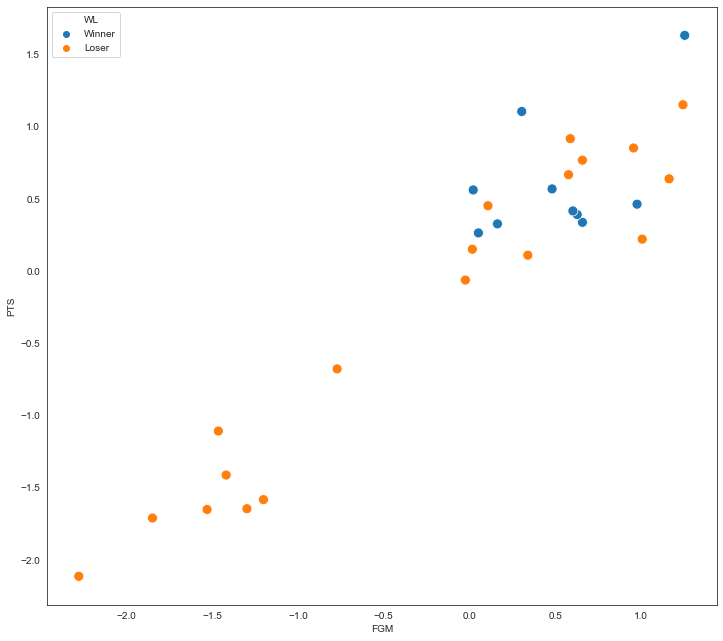

In [28]:
sns.scatterplot(scaled_stats_df.FGM, scaled_stats_df.PTS, hue = scaled_stats_df.WL, s = 100)

This visualization confirms our results from the hypothesis tests! It definitely looks like **the teams that beat the Bucks are higher up in the scoring department!**

### Boards Boards Boards!!!

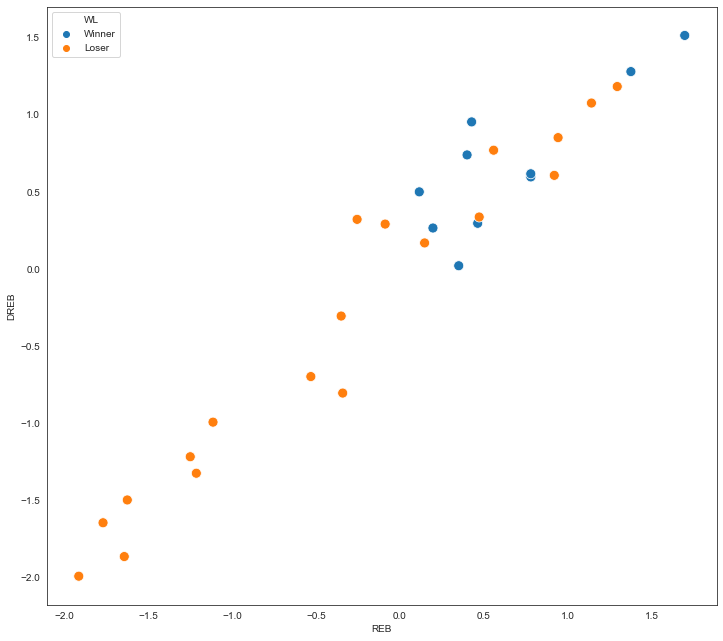

In [29]:
sns.scatterplot(scaled_stats_df.REB, scaled_stats_df.DREB, hue = scaled_stats_df.WL, s = 100)

Here, we can see that the teams that beat the Bucks are also **good rebounding teams!** Rebounding should be particularly useful against Giannis down low.

Now that we've determined some potentially winning traits of teams that are successful against Giannis, let's now look from inside the Bucks team. 

## Giannis Shot Selection

Let's first start with Giannis on offense. Where is Giannis taking most of his shots? How does his accuracy change depending on where he shoots? 

In [30]:
def shot_zones(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="black",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, ax=None, despine=False, **kwargs):
    
    if ax is None:
        ax = plt.gca()
        ax.set_facecolor(court_color)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)
    
    # draws the court
    # set shotzone to True
    draw_court(ax, color=line_color, lw=court_lw, shotzone=True, outer_lines=outer_lines)
    
    x_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_X']
    y_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_Y']
    
    x_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_X']
    y_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_Y']
    
    # plot missed shots
    ax.scatter(x_missed, y_missed, c='r', marker="x", s=300, linewidths=3, **kwargs)
    # plot made shots
    ax.scatter(x_made, y_made, facecolors='none', edgecolors='b', s=100, linewidths=3, **kwargs)
        
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

### Giannis Down Low

In [31]:
downLow = giannis_shots[(giannis_shots.SHOT_ZONE_BASIC == 'Restricted Area') | (giannis_shots.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)')]
print('Percentage of Shots Down Low:' , len(downLow)/len(giannis_shots))
print(downLow.EVENT_TYPE.value_counts(normalize = True))

Percentage of Shots Down Low: 0.6696284329563813
Made Shot      0.664656
Missed Shot    0.335344
Name: EVENT_TYPE, dtype: float64


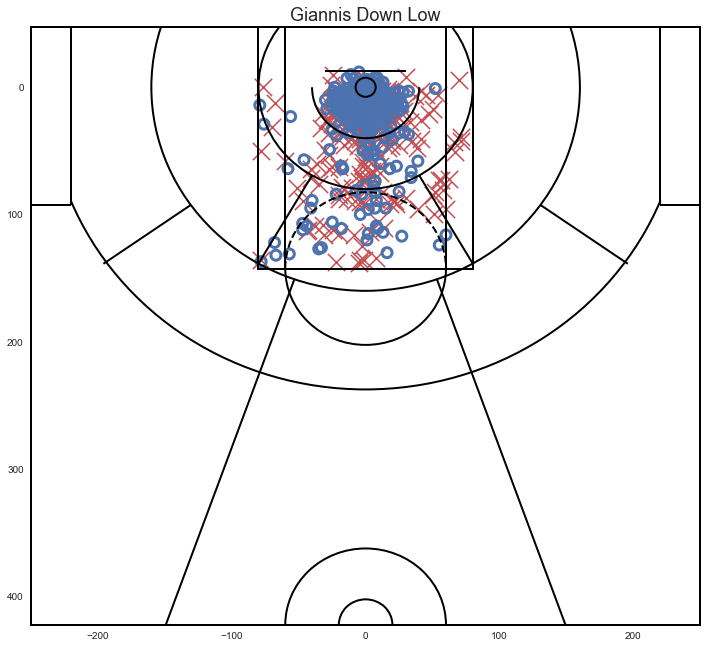

In [32]:
shot_zones(downLow, title = 'Giannis Down Low')

In [33]:
downLow.SHOT_ZONE_AREA.value_counts(normalize = True)

Center(C)        0.979493
Right Side(R)    0.012063
Left Side(L)     0.008444
Name: SHOT_ZONE_AREA, dtype: float64

### Giannis From Mid-Range

In [34]:
midRange = giannis_shots[(giannis_shots.SHOT_ZONE_BASIC == 'Mid-Range')]
print('Percentage of Shots Mid-Range:' , len(midRange)/len(giannis_shots))
print(midRange.EVENT_TYPE.value_counts(normalize = True))

Percentage of Shots Mid-Range: 0.09369951534733441
Missed Shot    0.612069
Made Shot      0.387931
Name: EVENT_TYPE, dtype: float64


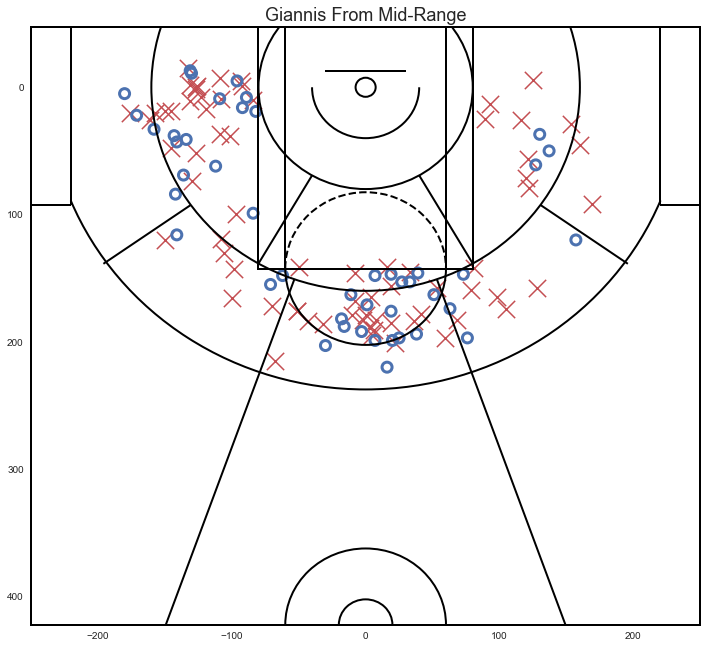

In [35]:
shot_zones(midRange, title = 'Giannis From Mid-Range')

In [36]:
midRange.SHOT_ZONE_AREA.value_counts(normalize = True)

Center(C)                0.362069
Left Side(L)             0.353448
Right Side(R)            0.112069
Right Side Center(RC)    0.094828
Left Side Center(LC)     0.077586
Name: SHOT_ZONE_AREA, dtype: float64

### Giannis From Deep

In [37]:
threes = giannis_shots[(giannis_shots.SHOT_ZONE_BASIC == 'Above the Break 3') | (giannis_shots.SHOT_ZONE_BASIC == 'Left Corner 3')| (giannis_shots.SHOT_ZONE_BASIC == 'Right Corner 3')]
print('Percentage of Shots Mid-Range:' , len(threes)/len(giannis_shots))
print(threes.EVENT_TYPE.value_counts(normalize = True))

Percentage of Shots Mid-Range: 0.23667205169628433
Missed Shot    0.696246
Made Shot      0.303754
Name: EVENT_TYPE, dtype: float64


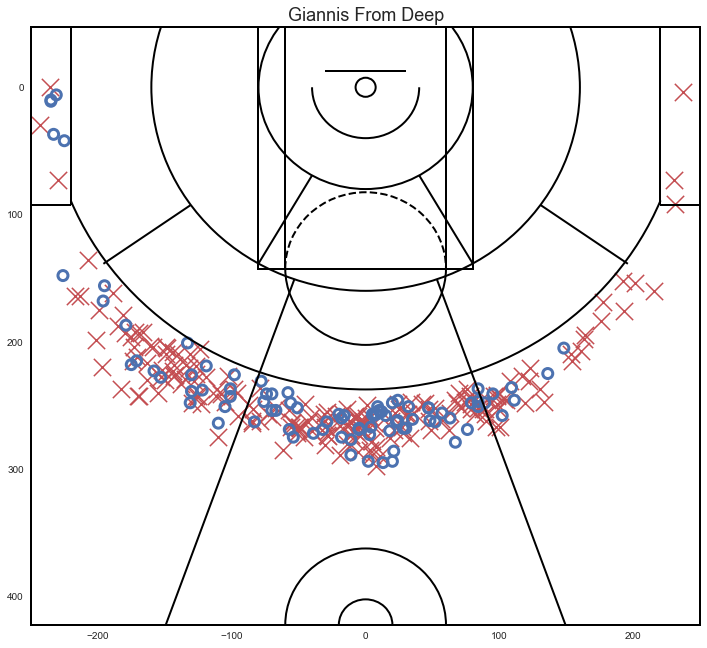

In [38]:
shot_zones(threes, title = 'Giannis From Deep')

In [39]:
threes.SHOT_ZONE_AREA.value_counts(normalize = True)

Center(C)                0.529010
Left Side Center(LC)     0.283276
Right Side Center(RC)    0.153584
Left Side(L)             0.027304
Right Side(R)            0.006826
Name: SHOT_ZONE_AREA, dtype: float64

A couple things we can infer:

**1) The farther Giannis shoots, the less accurate his shot is.**

Not only can we see this when we split his shots by region (Down Low, Mid-Range, Three), but we can also see his shot getting worse as he moves farther *within a region*.

**2) Yes, Giannis shoots a lot down low, but he is *less likely to take a mid-range jumper than a shot from beyond the arc.***

This makes a lot of sense to me. From a coaching perspective (and possibly his perspective), if Giannis is going to take a shot within the arc, that means he's attempting a basket worth two points. That being said, it makes more sense for Giannis to take a shot closer to the basket (Down Low) with a higher percentage since the point value would be the same.

This is a similar concept to an expected value $E[X]$. Say for example the probability that Giannis makes a shot in the paint is $p = 0.75$. Then, the expected number of points he makes would be $E[X] = 0.75 * 2 = 1.5$. Similarly if the probability that he makes a Mid-Range Jumper is $q = 0.25$, then the expected number of points he makes would be $E[X] = 0.25 * 2 = 0.5$... Therefore... **take it to the rim, Big Fella!**

**3) He likes taking jump shots from the left side more than the right.**

From three point land and mid-range, **Giannis took twice the amount of shots from the left side than the right side**. He also **becomes less accurate when he shoots on the right when compared to the left (threes and baseline mid-range shots**. This possibly could be due to him being right-handed and feeling more comfortable driving right.

### Who's Taking Advantage of This? 

Now that we have a better understanding of where Giannis lacks in shooting, does it show in the games that he loses?

Game: MIL @ BOS
FGA: 13
FGM: 8
FG_PCT: 0.615
FG3M: 0
FG3A: 2
FG3_PCT: 0.0
FG3A/FGA 0.15384615384615385
PTS: 22
- - - - - - - - - - - - - - -
Game: MIL vs. MIA
FGA: 21
FGM: 12
FG_PCT: 0.571
FG3M: 0
FG3A: 5
FG3_PCT: 0.0
FG3A/FGA 0.23809523809523808
PTS: 29
- - - - - - - - - - - - - - -
Game: MIL @ MIA
FGA: 18
FGM: 6
FG_PCT: 0.333
FG3M: 0
FG3A: 4
FG3_PCT: 0.0
FG3A/FGA 0.2222222222222222
PTS: 13
- - - - - - - - - - - - - - -
Game: MIL @ UTA
FGA: 22
FGM: 10
FG_PCT: 0.455
FG3M: 2
FG3A: 6
FG3_PCT: 0.333
FG3A/FGA 0.2727272727272727
PTS: 30
- - - - - - - - - - - - - - -
Game: MIL @ SAS
FGA: 22
FGM: 10
FG_PCT: 0.455
FG3M: 0
FG3A: 5
FG3_PCT: 0.0
FG3A/FGA 0.22727272727272727
PTS: 24
- - - - - - - - - - - - - - -
Game: MIL @ DAL
FGA: 26
FGM: 13
FG_PCT: 0.5
FG3M: 1
FG3A: 7
FG3_PCT: 0.143
FG3A/FGA 0.2692307692307692
PTS: 34
- - - - - - - - - - - - - - -
Game: MIL @ LAL
FGA: 21
FGM: 10
FG_PCT: 0.476
FG3M: 1
FG3A: 6
FG3_PCT: 0.167
FG3A/FGA 0.2857142857142857
PTS: 32
- - - - - - - - - - - - - - -
Game: 

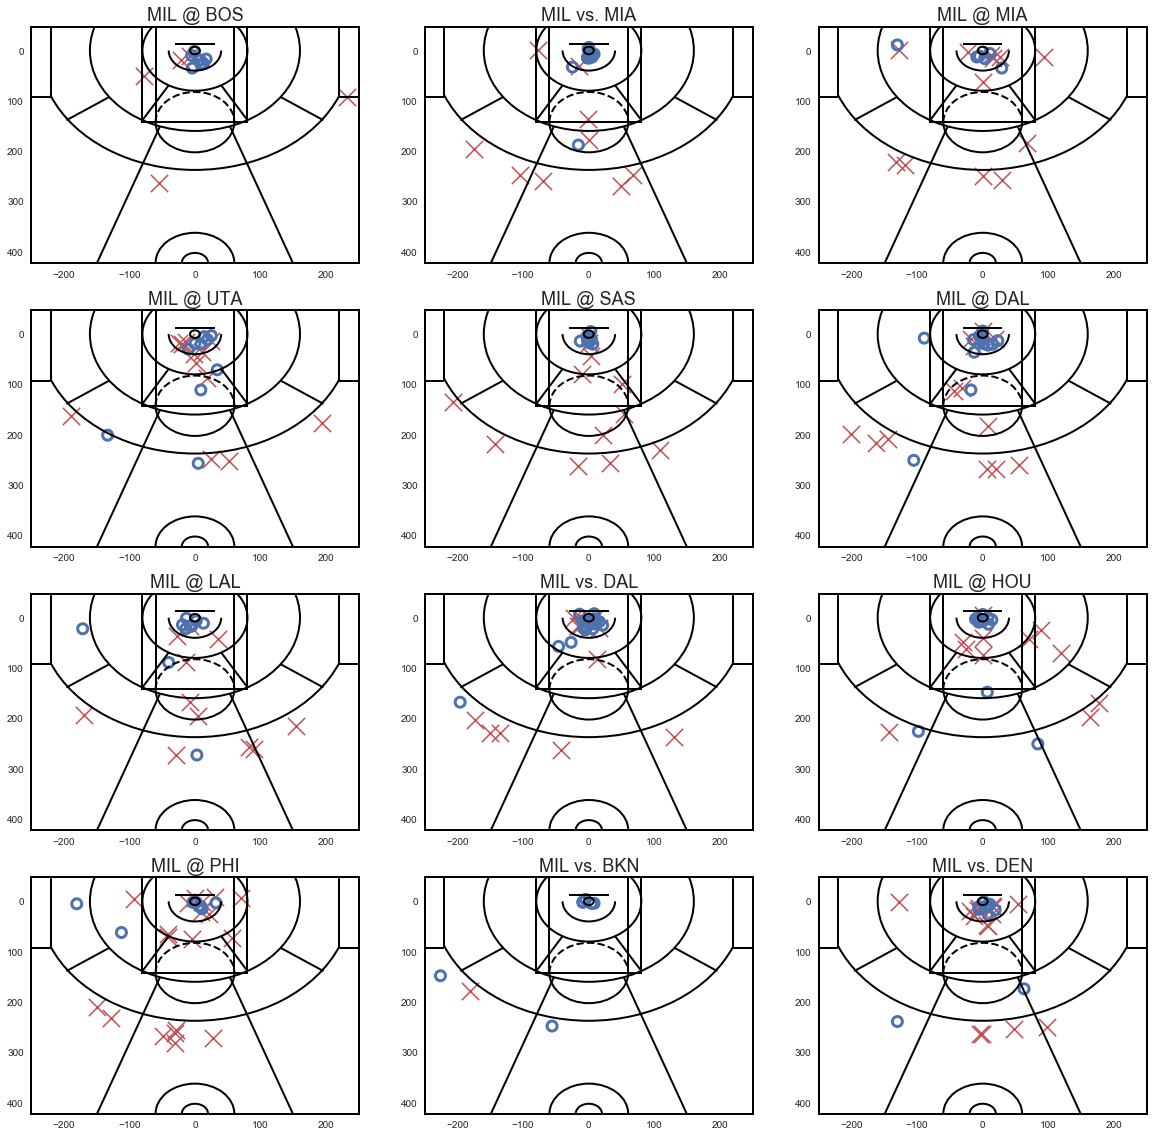

In [40]:
plt.rcParams['figure.figsize'] = [20,20]
for i in range(0, len(giannis_losing_games)):
    plt.subplot(4,3, i+1)
    game_shots = giannis_shots[giannis_shots.GAME_ID == giannis_losing_game_ids[i]].reset_index(drop = True)
    opponent = giannis_losing_games[giannis_losing_games['Game_ID'] == giannis_losing_game_ids[i]].reset_index(drop = True).MATCHUP[0]
    shot_zones(game_shots, title = opponent)
    
    game_stats = giannis_game_stats[giannis_game_stats.Game_ID == giannis_losing_game_ids[i]].reset_index(drop = True)
    print('Game:', opponent)
    print('FGA:', game_stats.FGA[0])
    print('FGM:', game_stats.FGM[0])
    print('FG_PCT:', game_stats.FG_PCT[0])
    print('FG3M:', game_stats.FG3M[0])
    print('FG3A:', game_stats.FG3A[0])
    print('FG3_PCT:', game_stats.FG3_PCT[0])
    print('FG3A/FGA', game_stats.FG3A[0]/game_stats.FGA[0])
    print('PTS:', game_stats.PTS[0])
    print('- - - - - - - - - - - - - - -')
    

In [41]:
# Get per game stats:

giannis_now = giannis_career_stats[giannis_career_stats.SEASON_ID == '2019-20'].reset_index(drop = True)
print('Giannis Per Game (2019-20)')
print ('- - - - - - - - - - - - -')
print('FGM:', giannis_now.FGM[0]/giannis_now.GP[0])
print('FGA:', giannis_now.FGA[0]/giannis_now.GP[0])
print('FG_PCT:', giannis_now.FG_PCT[0])
print('FG3M:', giannis_now.FG3M[0]/giannis_now.GP[0])
print('FG3A:', giannis_now.FG3A[0]/giannis_now.GP[0])
print('FG3_PCT:', giannis_now.FG3_PCT[0])
print('PTS:', giannis_now.PTS[0]/giannis_now.GP[0])

Giannis Per Game (2019-20)
- - - - - - - - - - - - -
FGM: 10.873015873015873
FGA: 19.650793650793652
FG_PCT: 0.553
FG3M: 1.4126984126984128
FG3A: 4.650793650793651
FG3_PCT: 0.304
PTS: 29.476190476190474


It seems like our theory on his selection may be true. **In 9 of the 12 losses that Giannis played in, he attempted more three's than he does on average (per game). Of those threes, the vast majority were taken from the left to center side of the arc.** 

## Multiple Linear Regression

**Motivation:** Sports betting and fantasy basketball have been million dollar industries over the past decade. For years, I've been picking personal favorites and going on "gut" feelings when picking my fantasy team. Having not won a single fantasy league yet, maybe this isn't the approach I should be taking. Let's take a more data-driven approach.

A key factor to succeeding in fantasy basketball is being able to determine which players will "go big" on a given night. Since we've been talking a lot about Giannis and the Bucks, can we develop a model that can predict how many points the Freak will score on a given night? 

In [152]:
import math
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

We have some of Giannis' individual game stats already... but can we do better? Can we create more offensive stats for Giannis?

* Number of shots taken down low
* Number of mid-range attempted
* Number of threes attempted
* Number of threes made by teammates

What about defensive stats for the opposing team?

* Average DREB
* Average STL
* Average BLK
* Opponent Second Point Chance given
* Opponent points in the paint 
* Team Defensive Rank
* Regular season record

Let's start with a data frame we've already seen, `giannis_game_stats`, and filter through some of his stats.

In [153]:
giannis_game_stats.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,203507,0021901303,"AUG 11, 2020",MIL @ WAS,W,10,1,3,0.333,0,0,0.000,10,12,0.833,2,7,9,1,1,0,3,2,12,12,1
1,22019,203507,0021901284,"AUG 08, 2020",MIL @ DAL,L,33,13,26,0.500,1,7,0.143,7,14,0.500,2,11,13,1,0,5,4,6,34,-16,1
2,22019,203507,0021901269,"AUG 06, 2020",MIL vs. MIA,W,30,13,17,0.765,0,4,0.000,7,9,0.778,1,11,12,4,0,1,6,5,33,15,1
3,22019,203507,0021901256,"AUG 04, 2020",MIL vs. BKN,L,16,7,8,0.875,2,3,0.667,0,3,0.000,0,6,6,4,0,0,3,1,16,4,1
4,22019,203507,0021901248,"AUG 02, 2020",MIL @ HOU,L,33,14,25,0.560,2,5,0.400,6,9,0.667,4,14,18,8,0,1,3,3,36,1,1


This will be our base data frame after collecting the rest of the data. Though this gives us great insight on how he did on a given night, we don't really need all of these stats. We need to remember our goal: create a model that predicts how many points he will **score** on a given night. Thus, we can do an early pre-processing step of getting rid of some features that shouldn't help us reach our goal.

In [154]:
model_stats = giannis_game_stats.loc[:, ['Game_ID', 'GAME_DATE', 'MATCHUP','FTA', 'OREB', 'AST', 'STL', 'BLK', 'PF']]
model_stats

,Game_ID,GAME_DATE,MATCHUP,FTA,OREB,AST,STL,BLK,PF
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2
1,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6
2,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5
3,0021901256,"AUG 04, 2020",MIL vs. BKN,3,0,4,0,0,1
4,0021901248,"AUG 02, 2020",MIL @ HOU,9,4,8,0,1,3
...,...,...,...,...,...,...,...,...,...
58,0021900071,"NOV 01, 2019",MIL @ ORL,11,2,6,2,0,4
59,0021900058,"OCT 30, 2019",MIL @ BOS,10,1,5,1,2,4
60,0021900046,"OCT 28, 2019",MIL vs. CLE,8,1,7,0,2,2
61,0021900026,"OCT 26, 2019",MIL vs. MIA,9,3,9,3,2,6


These are the features that I decided to keep from the original data frame. Take special notice that I did **not** include "makes" as input features. Why?

### A quick math detour: Multiple Linear Regression

The model that we will pay special attention to is a *multiple linear regression*. In math talk, we want to model this equation:

$y = \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

Here, $y$ is the **actual** number of points Giannis scores and each $x_i$ is some stat. In theory, there is some perfect combination of these stats that can return the number of points he will score. However, since it is nearly impossible to create this perfect combination, statisticians create models for their best guess!

$\hat{y} = \hat{\beta_1}x_1 + \hat{\beta_2}x_2 + ... + \hat{\beta_n}x_n + \hat{\epsilon}$

Here, $\hat{y}$ is the **predicted** number of points that our model thinks he will score. I won't get into the specifics on how the model is built (i.e. how it comes up with the "right" combination of stats), so I'll leave you [this resource!](http://mezeylab.cb.bscb.cornell.edu/labmembers/documents/supplement%205%20-%20multiple%20regression.pdf)

Now, how does this relate to me not including "makes" stats into the model? Remember, the model is trying to figure out the right combination of these stats will produce the correct number of points scored. By putting in stats like "number of field goals made" and "number of three pointers made," **the model will predict the score correctly every single time**. For example, if Giannis made 3 three pointers and 4 dunks, even I can figure out his total score was $3*3 + 4*2 = 9 + 8 = 17$ points. More importantly, the model will figure out that it only needs these stat lines and can disregard all of the other stats.

This isn't very interesting. The whole point is that **we don't know how many points he'll make**. On a deeper level, we want to know the circumstances in which he is scoring and how that affects his ability to score.

### Getting number of shots by type

Instead of gathering information on the number of makes he has, we can instead collect the number of attempts he had. We previously saw that Giannis' accuracy varies depending on his location, so this should be useful when predicting the number of points he makes.

In [155]:
# First need to create new feature
shot_area = []
for zone in giannis_shots.SHOT_ZONE_BASIC:
    if zone in ['Restricted Area', 'In The Paint (Non-RA)']:
        shot_area.append('down_low')
    elif zone == 'Mid-Range':
        shot_area.append('mid_range')
    else:
        shot_area.append('three')
        
giannis_shots['shot_area'] = shot_area

df = pd.DataFrame(giannis_shots.groupby(['GAME_ID','shot_area']).count().iloc[:,1].unstack(fill_value=0).stack())
df.reset_index(inplace = True)
df = df.rename(columns = {0:'count', 'GAME_ID' : 'Game_ID'})
df = df.pivot_table('count', ['Game_ID'], 'shot_area').reset_index()
df

shot_area,Game_ID,down_low,mid_range,three
0,0021900015,9,3,5
1,0021900026,14,2,5
2,0021900046,11,2,2
3,0021900058,11,0,2
4,0021900071,12,0,4
...,...,...,...,...
58,0021901248,17,3,5
59,0021901256,5,0,3
60,0021901269,12,1,4
61,0021901284,17,2,7


In [156]:
model_stats = model_stats.merge(right = df.loc[:,['Game_ID','down_low', 'mid_range', 'three']], on = 'Game_ID')
model_stats

,Game_ID,GAME_DATE,MATCHUP,FTA,OREB,AST,STL,BLK,PF,down_low,mid_range,three
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2,2,1,0
1,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6,17,2,7
2,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5,12,1,4
3,0021901256,"AUG 04, 2020",MIL vs. BKN,3,0,4,0,0,1,5,0,3
4,0021901248,"AUG 02, 2020",MIL @ HOU,9,4,8,0,1,3,17,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...
58,0021900071,"NOV 01, 2019",MIL @ ORL,11,2,6,2,0,4,12,0,4
59,0021900058,"OCT 30, 2019",MIL @ BOS,10,1,5,1,2,4,11,0,2
60,0021900046,"OCT 28, 2019",MIL vs. CLE,8,1,7,0,2,2,11,2,2
61,0021900026,"OCT 26, 2019",MIL vs. MIA,9,3,9,3,2,6,14,2,5


Not only can we get the number of baskets that Giannis attempts, but I think we should also include the number of baskets his teammates make. If the rest of the Bucks are shooting well from deep, this spreads the defense out and lets Giannis go to work down low with more ease. Let's get **the number of threes made by his teammates**.

In [157]:
# First, need to get games where Giannis actually played
giannis_playing_ids = list(set(giannis_shots.GAME_ID).intersection(bucks_game_stats.Game_ID))
bucks_game_stats_with_giannis = bucks_game_stats[bucks_game_stats.Game_ID.isin(giannis_playing_ids)].reset_index(drop = True)
bucks_game_stats_with_giannis

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612749,0021901303,"AUG 11, 2020",MIL @ WAS,W,56,16,0.778,240,44,87,0.506,18,38,0.474,20,28,0.714,9,44,53,25,6,0,14,26,126
1,1610612749,0021901284,"AUG 08, 2020",MIL @ DAL,L,55,15,0.786,265,47,99,0.475,15,44,0.341,23,34,0.676,9,46,55,26,3,9,13,26,132
2,1610612749,0021901269,"AUG 06, 2020",MIL vs. MIA,W,55,14,0.797,240,41,78,0.526,15,37,0.405,33,38,0.868,5,39,44,27,7,3,14,21,130
3,1610612749,0021901256,"AUG 04, 2020",MIL vs. BKN,L,54,14,0.794,240,42,88,0.477,17,51,0.333,15,23,0.652,7,47,54,28,3,5,18,19,116
4,1610612749,0021901248,"AUG 02, 2020",MIL @ HOU,L,54,13,0.806,240,45,92,0.489,9,35,0.257,17,23,0.739,17,48,65,21,6,6,22,23,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1610612749,0021900071,"NOV 01, 2019",MIL @ ORL,W,3,2,0.600,240,47,93,0.505,17,47,0.362,12,18,0.667,11,47,58,24,11,4,13,19,123
59,1610612749,0021900058,"OCT 30, 2019",MIL @ BOS,L,2,2,0.500,240,38,82,0.463,14,45,0.311,15,24,0.625,5,40,45,21,3,4,15,21,105
60,1610612749,0021900046,"OCT 28, 2019",MIL vs. CLE,W,2,1,0.667,240,48,92,0.522,17,38,0.447,16,24,0.667,8,42,50,29,9,7,12,15,129
61,1610612749,0021900026,"OCT 26, 2019",MIL vs. MIA,L,1,1,0.500,265,41,94,0.436,17,54,0.315,27,35,0.771,5,42,47,22,8,4,18,32,126


In [158]:
model_stats['FG3M_team'] = bucks_game_stats_with_giannis.FG3M - giannis_game_stats.FG3M
model_stats

,Game_ID,GAME_DATE,MATCHUP,FTA,OREB,AST,STL,BLK,PF,down_low,mid_range,three,FG3M_team
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2,2,1,0,18
1,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6,17,2,7,14
2,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5,12,1,4,15
3,0021901256,"AUG 04, 2020",MIL vs. BKN,3,0,4,0,0,1,5,0,3,15
4,0021901248,"AUG 02, 2020",MIL @ HOU,9,4,8,0,1,3,17,3,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0021900071,"NOV 01, 2019",MIL @ ORL,11,2,6,2,0,4,12,0,4,16
59,0021900058,"OCT 30, 2019",MIL @ BOS,10,1,5,1,2,4,11,0,2,14
60,0021900046,"OCT 28, 2019",MIL vs. CLE,8,1,7,0,2,2,11,2,2,17
61,0021900026,"OCT 26, 2019",MIL vs. MIA,9,3,9,3,2,6,14,2,5,17


Let's also get some information on the team he was playing that night.

In [159]:
model_stats.head()

,Game_ID,GAME_DATE,MATCHUP,FTA,OREB,AST,STL,BLK,PF,down_low,mid_range,three,FG3M_team
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2,2,1,0,18
1,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6,17,2,7,14
2,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5,12,1,4,15
3,0021901256,"AUG 04, 2020",MIL vs. BKN,3,0,4,0,0,1,5,0,3,15
4,0021901248,"AUG 02, 2020",MIL @ HOU,9,4,8,0,1,3,17,3,5,7


In [160]:
# Get the Opponent team abbreviation
opponent_lst = []
for matchup in model_stats.MATCHUP:
    opponent = matchup.split(' ')[2]
    opponent_lst.append(opponent)
model_stats['opponent_abb'] = opponent_lst

# Get the opponent team information from different table
team_metrics = teamestimatedmetrics.TeamEstimatedMetrics(season = '2019-20').get_data_frames()[0]
team_abb = ['LAL', 'MIL', 'LAC', 'TOR', 'DEN', 'BOS', 'HOU', 'IND', 'MIA', 'OKC',
           'UTA', 'PHI', 'DAL', 'BKN', 'ORL', 'POR', 'MEM', 'WAS', 'CHA', 'PHX',
           'CHI', 'SAS', 'NYK', 'SAC', 'DET', 'NOP','MIN', 'ATL', 'CLE', 'GSW']
league_standings['team_abb'] = team_abb
model_stats = model_stats.merge(right = league_standings.loc[:, ['TeamID', 'team_abb']], left_on = 'opponent_abb', right_on = 'team_abb')
model_stats = model_stats.merge(right = team_metrics.loc[:, ['TEAM_ID','E_DEF_RATING', 'E_PACE', 'E_DREB_PCT','W']], left_on = 'TeamID', right_on = 'TEAM_ID')
model_stats

,Game_ID,GAME_DATE,MATCHUP,FTA,OREB,AST,STL,BLK,PF,down_low,mid_range,three,FG3M_team,opponent_abb,TeamID,team_abb,TEAM_ID,E_DEF_RATING,E_PACE,E_DREB_PCT,W
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2,2,1,0,18,WAS,1610612764,WAS,1610612764,112.7,105.2,0.753,25
1,0021900851,"FEB 24, 2020",MIL @ WAS,8,2,2,0,1,6,9,3,0,17,WAS,1610612764,WAS,1610612764,112.7,105.2,0.753,25
2,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6,17,2,7,14,DAL,1610612742,DAL,1610612742,109.5,101.7,0.777,43
3,0021900398,"DEC 16, 2019",MIL vs. DAL,16,4,4,1,1,3,25,0,6,10,DAL,1610612742,DAL,1610612742,109.5,101.7,0.777,43
4,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5,12,1,4,15,MIA,1610612748,MIA,1610612748,107.2,100.5,0.795,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0021900111,"NOV 06, 2019",MIL @ LAC,18,4,9,2,2,4,9,5,7,14,LAC,1610612746,LAC,1610612746,105.3,103.9,0.776,49
59,0021900261,"NOV 27, 2019",MIL vs. ATL,13,2,4,0,4,5,16,2,5,9,ATL,1610612737,ATL,1610612737,112.3,105.6,0.749,20
60,0021900204,"NOV 20, 2019",MIL @ ATL,13,0,4,0,1,2,10,1,6,16,ATL,1610612737,ATL,1610612737,112.3,105.6,0.749,20
61,0021900248,"NOV 25, 2019",MIL vs. UTA,19,6,6,2,0,1,20,3,8,10,UTA,1610612755,UTA,1610612755,106.3,101.3,0.803,43


The Team Estimated Metrics table is pretty limited, in that it only has data based on the entire season. Yes, we do want to know what kind of team the Bucks will go against in an overall sense, but we are also (perhaps more) interested in how that team performed during that particular game. Let's get this information.

In [161]:
opponent_game_dfs = []
for team in model_stats.TeamID.unique():
    
    # Get other team's games
    team_games = teamgamelog.TeamGameLog(team_id = team).get_data_frames()[0]
    time.sleep(2)
    
    # Filter out to just Bucks' games
    opponent_list = []
    for matchup in team_games.MATCHUP:
        opponent = matchup.split(' ')[2]
        opponent_list.append(opponent)
    team_games['opponent'] = opponent_list
    games_vs_bucks = team_games[team_games['opponent'] == 'MIL']
    games_vs_bucks = games_vs_bucks.loc[:,['Game_ID','DREB', 'STL','TOV', 'PTS', 'BLK', 'PF']]
    
    #
    opponent_game_dfs.append(games_vs_bucks)
    
opponent_game_stats_df = pd.concat(opponent_game_dfs)
opponent_game_stats_df = opponent_game_stats_df.reset_index(drop = True)
opponent_game_stats_df.head()

,Game_ID,DREB,STL,TOV,PTS,BLK,PF
0,0021901303,33,2,11,113,3,23
1,0021900851,35,8,17,134,0,27
2,0021900705,24,6,10,131,6,27
3,0021901284,43,6,6,136,2,26
4,0021900398,44,5,14,120,6,23


In [162]:
model_stats = model_stats.merge(right = opponent_game_stats_df, on = 'Game_ID')
model_stats

,Game_ID,GAME_DATE,MATCHUP,FTA,OREB,AST,STL_x,BLK_x,PF_x,down_low,mid_range,three,FG3M_team,opponent_abb,TeamID,team_abb,TEAM_ID,E_DEF_RATING,E_PACE,E_DREB_PCT,W,DREB,STL_y,TOV,PTS,BLK_y,PF_y
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2,2,1,0,18,WAS,1610612764,WAS,1610612764,112.7,105.2,0.753,25,33,2,11,113,3,23
1,0021900851,"FEB 24, 2020",MIL @ WAS,8,2,2,0,1,6,9,3,0,17,WAS,1610612764,WAS,1610612764,112.7,105.2,0.753,25,35,8,17,134,0,27
2,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6,17,2,7,14,DAL,1610612742,DAL,1610612742,109.5,101.7,0.777,43,43,6,6,136,2,26
3,0021900398,"DEC 16, 2019",MIL vs. DAL,16,4,4,1,1,3,25,0,6,10,DAL,1610612742,DAL,1610612742,109.5,101.7,0.777,43,44,5,14,120,6,23
4,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5,12,1,4,15,MIA,1610612748,MIA,1610612748,107.2,100.5,0.795,44,33,6,19,116,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0021900111,"NOV 06, 2019",MIL @ LAC,18,4,9,2,2,4,9,5,7,14,LAC,1610612746,LAC,1610612746,105.3,103.9,0.776,49,40,4,19,124,3,28
59,0021900261,"NOV 27, 2019",MIL vs. ATL,13,2,4,0,4,5,16,2,5,9,ATL,1610612737,ATL,1610612737,112.3,105.6,0.749,20,35,4,17,102,5,25
60,0021900204,"NOV 20, 2019",MIL @ ATL,13,0,4,0,1,2,10,1,6,16,ATL,1610612737,ATL,1610612737,112.3,105.6,0.749,20,34,8,13,127,2,26
61,0021900248,"NOV 25, 2019",MIL vs. UTA,19,6,6,2,0,1,20,3,8,10,UTA,1610612755,UTA,1610612755,106.3,101.3,0.803,43,36,4,16,118,6,23


In [163]:
# Renaming columns
model_stats = model_stats.rename(columns = {'FGA' : 'giannis_FGA',
                              'FG3A' : 'giannis_FG3A',
                             'FTA' : 'giannis_FTA',
                             'OREB': 'giannis_OREB',
                             'AST' : 'giannis_AST',
                             'STL_x': 'giannis_STL',
                             'BLK_x': 'giannis_BLK',
                             'PF_x': 'giannis_PF',
                             'STL_y': 'opp_STL',
                             'TOV': 'opp_TOV',
                             'PTS': 'opp_PTS',
                             'BLK_y': 'opp_BLK',
                            'DREB' : 'opp_DREB',
                             'PF_y': 'opp_PF'})
model_stats.head()

,Game_ID,GAME_DATE,MATCHUP,giannis_FTA,giannis_OREB,giannis_AST,giannis_STL,giannis_BLK,giannis_PF,down_low,mid_range,three,FG3M_team,opponent_abb,TeamID,team_abb,TEAM_ID,E_DEF_RATING,E_PACE,E_DREB_PCT,W,opp_DREB,opp_STL,opp_TOV,opp_PTS,opp_BLK,opp_PF
0,0021901303,"AUG 11, 2020",MIL @ WAS,12,2,1,1,0,2,2,1,0,18,WAS,1610612764,WAS,1610612764,112.7,105.2,0.753,25,33,2,11,113,3,23
1,0021900851,"FEB 24, 2020",MIL @ WAS,8,2,2,0,1,6,9,3,0,17,WAS,1610612764,WAS,1610612764,112.7,105.2,0.753,25,35,8,17,134,0,27
2,0021901284,"AUG 08, 2020",MIL @ DAL,14,2,1,0,5,6,17,2,7,14,DAL,1610612742,DAL,1610612742,109.5,101.7,0.777,43,43,6,6,136,2,26
3,0021900398,"DEC 16, 2019",MIL vs. DAL,16,4,4,1,1,3,25,0,6,10,DAL,1610612742,DAL,1610612742,109.5,101.7,0.777,43,44,5,14,120,6,23
4,0021901269,"AUG 06, 2020",MIL vs. MIA,9,1,4,0,1,5,12,1,4,15,MIA,1610612748,MIA,1610612748,107.2,100.5,0.795,44,33,6,19,116,1,28


Now that we finally have all of the features that we want, let's now filter out the features that we won't be needing for our model. What's left will be our **feature matrix**, $X$.

In [164]:
X = model_stats.loc[:, ['giannis_FTA', 'giannis_AST',
                       'giannis_STL', 'giannis_BLK', 'giannis_PF', 'down_low', 'mid_range',
                       'three', 'FG3M_team', 'E_DEF_RATING', 'E_PACE', 'E_DREB_PCT', 'opp_DREB',
                       'opp_STL', 'opp_TOV', 'opp_PTS', 'opp_BLK', 'opp_PF']]
X

,giannis_FTA,giannis_AST,giannis_STL,giannis_BLK,giannis_PF,down_low,mid_range,three,FG3M_team,E_DEF_RATING,E_PACE,E_DREB_PCT,opp_DREB,opp_STL,opp_TOV,opp_PTS,opp_BLK,opp_PF
0,12,1,1,0,2,2,1,0,18,112.7,105.2,0.753,33,2,11,113,3,23
1,8,2,0,1,6,9,3,0,17,112.7,105.2,0.753,35,8,17,134,0,27
2,14,1,0,5,6,17,2,7,14,109.5,101.7,0.777,43,6,6,136,2,26
3,16,4,1,1,3,25,0,6,10,109.5,101.7,0.777,44,5,14,120,6,23
4,9,4,0,1,5,12,1,4,15,107.2,100.5,0.795,33,6,19,116,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,18,9,2,2,4,9,5,7,14,105.3,103.9,0.776,40,4,19,124,3,28
59,13,4,0,4,5,16,2,5,9,112.3,105.6,0.749,35,4,17,102,5,25
60,13,4,0,1,2,10,1,6,16,112.3,105.6,0.749,34,8,13,127,2,26
61,19,6,2,0,1,20,3,8,10,106.3,101.3,0.803,36,4,16,118,6,23


Now we will scale the data. Scaling our feature matrix is important because it allows us to put all of the features on a level playing field. For example, `E_DEF_RATING` and `giannis_FGA` are on completely different unit scales, so we need a way to level things out.

In [165]:
scaler = StandardScaler()
X_features = X.columns
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = X_features

X

,giannis_FTA,giannis_AST,giannis_STL,giannis_BLK,giannis_PF,down_low,mid_range,three,FG3M_team,E_DEF_RATING,E_PACE,E_DREB_PCT,opp_DREB,opp_STL,opp_TOV,opp_PTS,opp_BLK,opp_PF
0,0.489382,-1.665006,0.034310,-0.987829,-0.706439,-2.562759,-0.608512,-2.270568,1.775842,1.513429,1.451837,-1.443994,-0.734065,-1.815190,-0.656767,0.421316,-0.549655,0.256227
1,-0.481675,-1.304541,-1.046449,-0.044901,1.873600,-0.955111,0.838140,-2.270568,1.468485,1.513429,1.451837,-1.443994,-0.282884,0.302532,0.965834,2.100237,-1.816543,1.140737
2,0.974910,-1.665006,-1.046449,3.726810,1.873600,0.882202,0.114814,1.146908,0.546413,0.347562,-0.324689,0.174478,1.521842,-0.403376,-2.008935,2.260134,-0.971951,0.919610
3,1.460439,-0.583610,0.034310,-0.044901,-0.061430,2.719514,-1.331839,0.658697,-0.683016,0.347562,-0.324689,0.174478,1.747432,-0.756329,0.154533,0.980957,0.717233,0.256227
4,-0.238911,-0.583610,-1.046449,-0.044901,1.228590,-0.266119,-0.608512,-0.317724,0.853770,-0.490404,-0.933784,1.388333,-0.734065,-0.403376,1.506701,0.661162,-1.394247,1.361865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1.945967,1.218716,1.115069,0.898027,0.583580,-0.955111,2.284792,1.146908,0.546413,-1.182637,0.791984,0.107042,0.845070,-1.109283,1.506701,1.300751,-0.549655,1.361865
59,0.732146,-0.583610,-1.046449,2.783882,1.228590,0.652538,0.114814,0.170486,-0.990374,1.367696,1.654868,-1.713740,-0.282884,-1.109283,0.965834,-0.458118,0.294937,0.698482
60,0.732146,-0.583610,-1.046449,-0.044901,-0.706439,-0.725447,-0.608512,0.658697,1.161128,1.367696,1.654868,-1.713740,-0.508474,0.302532,-0.115900,1.540597,-0.971951,0.919610
61,2.188731,0.137320,1.115069,-0.987829,-1.351449,1.571194,0.838140,1.635119,-0.683016,-0.818304,-0.527721,1.927824,-0.057293,-1.109283,0.695401,0.821059,0.717233,0.256227


### Checking for Multicolinearity

In [166]:
corr_matrix = X.corr()
corr_matrix

,giannis_FTA,giannis_AST,giannis_STL,giannis_BLK,giannis_PF,down_low,mid_range,three,FG3M_team,E_DEF_RATING,E_PACE,E_DREB_PCT,opp_DREB,opp_STL,opp_TOV,opp_PTS,opp_BLK,opp_PF
giannis_FTA,1.000000,-0.063035,0.137299,0.098277,0.358146,0.177138,-0.053400,0.247671,-0.076721,0.088091,0.030785,-0.063039,0.129745,-0.056929,0.144255,0.349581,-0.007646,0.460847
giannis_AST,-0.063035,1.000000,0.205536,0.060117,-0.069066,0.118015,0.187027,-0.034585,0.169412,-0.317057,-0.045444,0.062471,0.078859,0.140210,-0.080019,0.029516,0.425833,-0.023798
giannis_STL,0.137299,0.205536,1.000000,-0.063163,0.035303,0.229763,-0.041165,0.211906,-0.050383,-0.035050,-0.247472,0.166386,0.292215,-0.070929,0.296250,0.128182,0.055081,0.105012
giannis_BLK,0.098277,0.060117,-0.063163,1.000000,0.190320,0.225232,-0.005671,0.014962,-0.044469,-0.050921,-0.048006,-0.184947,0.213520,-0.292812,-0.102347,0.272597,0.038525,0.170368
giannis_PF,0.358146,-0.069066,0.035303,0.190320,1.000000,0.122383,-0.104031,-0.049508,-0.016783,0.015755,0.209750,0.023836,0.245923,0.014971,0.308520,0.246067,-0.111589,0.448156
down_low,0.177138,0.118015,0.229763,0.225232,0.122383,1.000000,-0.132931,0.207327,-0.300532,-0.014690,-0.130815,0.102729,0.119624,0.121683,0.076615,0.095508,0.272461,-0.113188
mid_range,-0.053400,0.187027,-0.041165,-0.005671,-0.104031,-0.132931,1.000000,0.058900,-0.143900,-0.225214,0.071662,0.193664,-0.003782,-0.006368,-0.008428,0.032404,0.009774,0.061980
three,0.247671,-0.034585,0.211906,0.014962,-0.049508,0.207327,0.058900,1.000000,-0.262266,-0.210587,-0.135809,0.213258,0.107666,0.014067,-0.013772,0.119613,0.067528,0.089978
FG3M_team,-0.076721,0.169412,-0.050383,-0.044469,-0.016783,-0.300532,-0.143900,-0.262266,1.000000,0.097149,-0.061303,-0.240427,-0.038031,-0.239351,-0.178114,0.174653,-0.105531,-0.037519
E_DEF_RATING,0.088091,-0.317057,-0.035050,-0.050921,0.015755,-0.014690,-0.225214,-0.210587,0.097149,1.000000,0.036207,-0.286524,-0.162341,0.032629,-0.052615,0.038968,-0.239026,0.071306


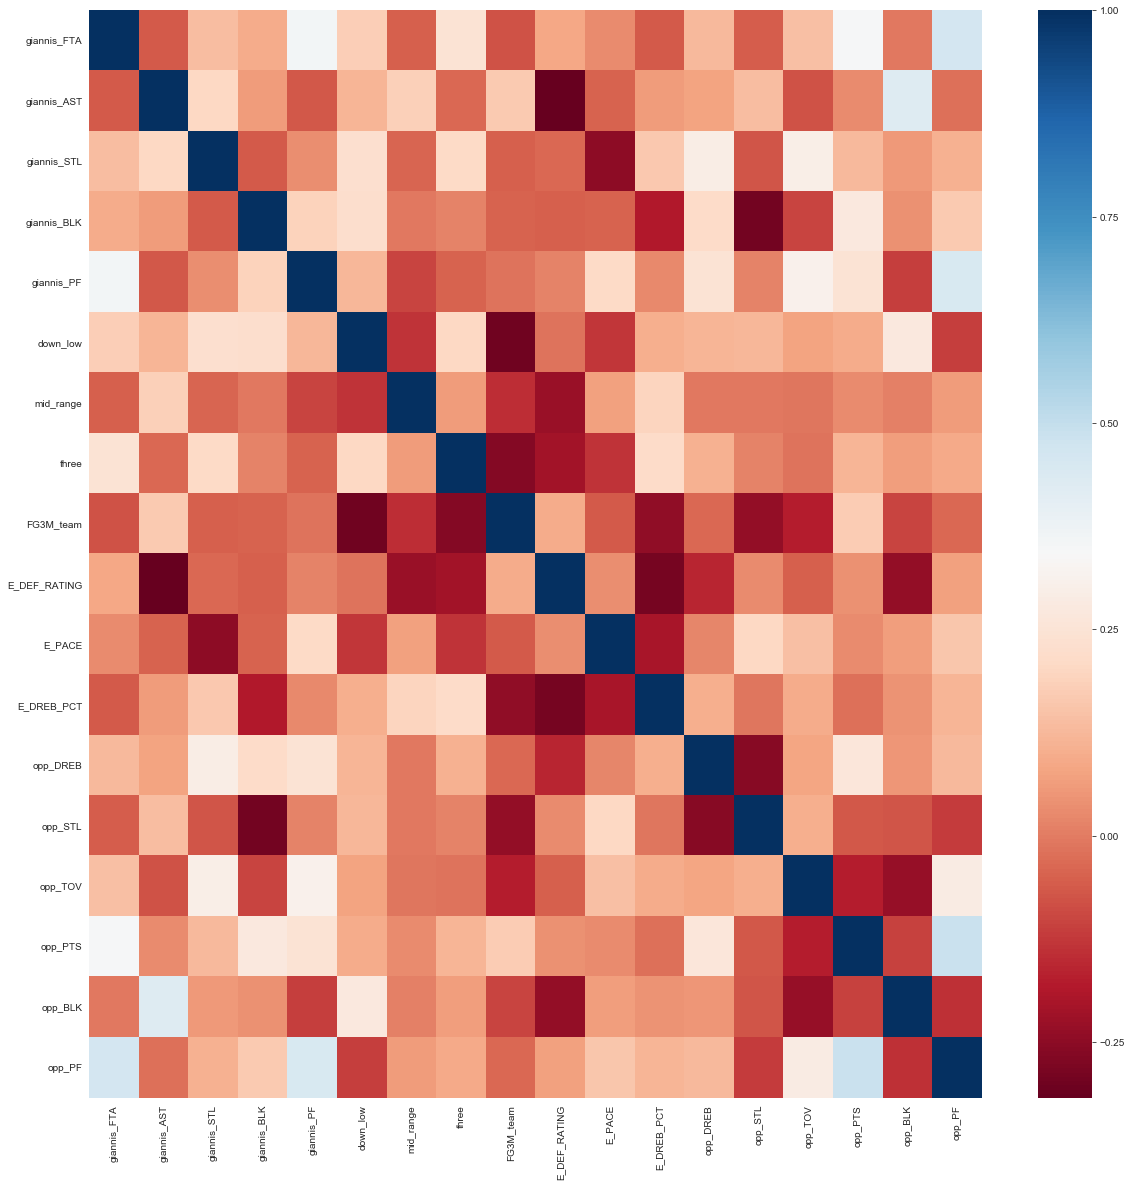

In [167]:
sns.heatmap(corr_matrix, xticklabels = corr_matrix.columns, yticklabels = corr_matrix.columns, cmap = 'RdBu')

It looks like there are quite a few different features that are correlated with each other... and that makes sense. Take FGA and FGM for example, if you attempt for field goals, you will make more shots! We do not want to include features that are highly correlated with one another because this will give us inaccurate results. How do we fix this?

We need a system to delete highly correlated variables from the model. Instead of just simply pulling out all highly correlated features, we can use `variance_inflation_factor`. This is a measure of how much a particular variable is contributing to the standard error in the regression model. When *significant* multicolinearity exists, the variance inflation factor will be huge for the variables in the calculation.

In [168]:
X_constant = sm.tools.add_constant(X)
pd.Series([variance_inflation_factor(X_constant.values,i) for i in range(X_constant.shape[1])], index = X_constant.columns)

/Users/tylerchang/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const           1.000000
giannis_FTA     1.597809
giannis_AST     1.909076
giannis_STL     1.639251
giannis_BLK     1.593268
giannis_PF      1.640613
down_low        1.781220
mid_range       1.249607
three           1.361556
FG3M_team       1.773752
E_DEF_RATING    1.470721
E_PACE          1.432239
E_DREB_PCT      1.486671
opp_DREB        1.425007
opp_STL         1.726097
opp_TOV         1.945671
opp_PTS         2.191937
opp_BLK         1.761282
opp_PF          2.528108
dtype: float64

Here, the rule of thumb is to **remove the features with a variance inflation factor of 5 or greater.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2e3e1d3d0>,
      dtype=object)

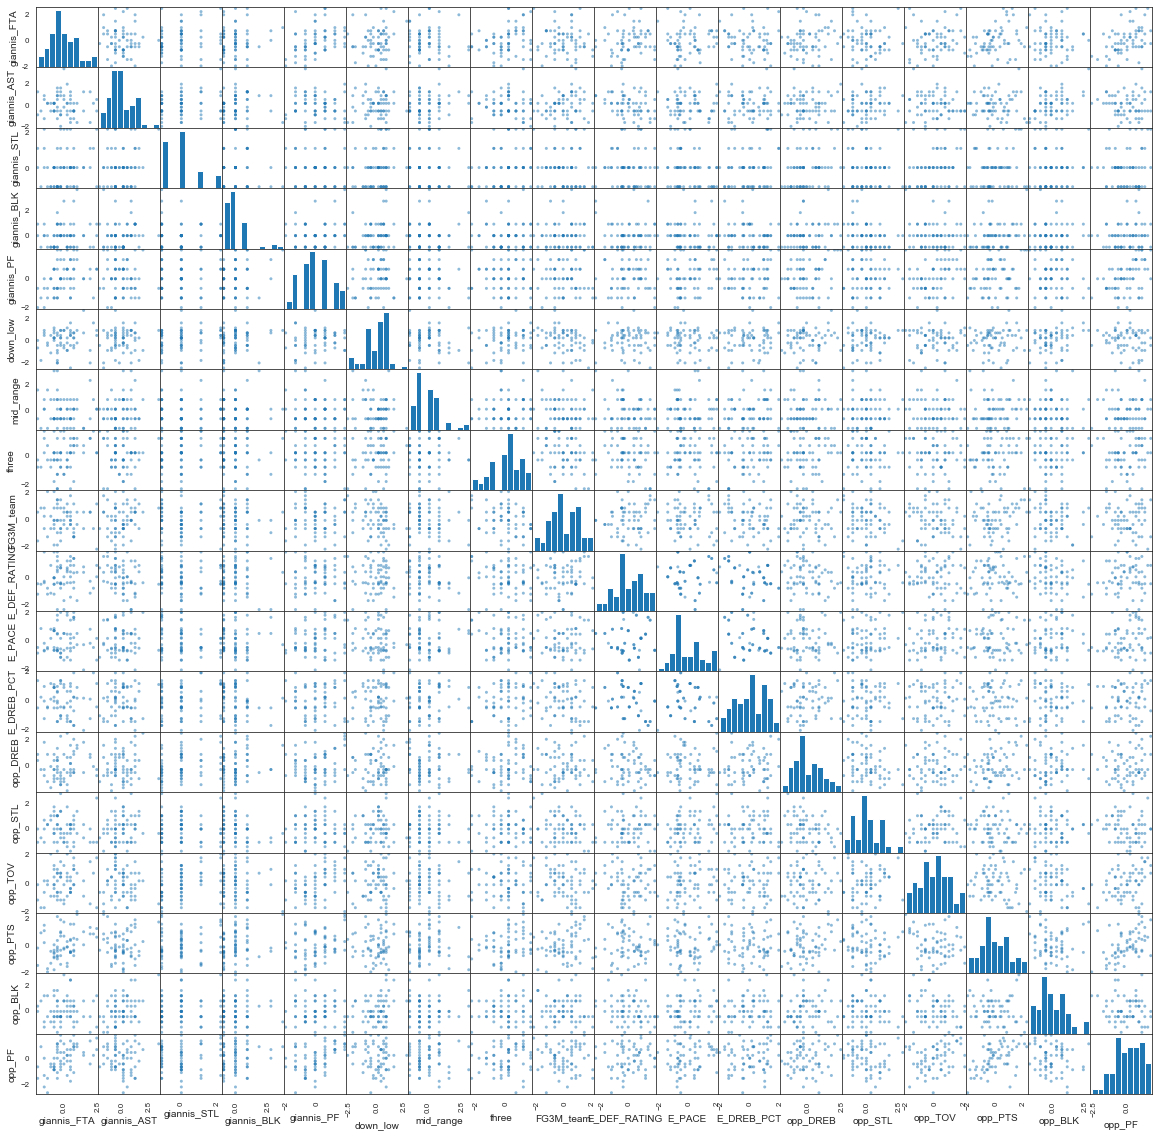

In [169]:
pd.plotting.scatter_matrix(X)

In [170]:
y = scaler.fit_transform(np.array(giannis_game_stats.PTS).reshape(-1, 1))
y

array([[-2.29231775],
       [ 0.59337925],
       [ 0.46221121],
       [-1.76764557],
       [ 0.85571534],
       [ 0.85571534],
       [ 0.33104316],
       [-0.06246097],
       [-2.1611497 ],
       [ 1.51155557],
       [ 0.33104316],
       [-1.37414143],
       [-0.98063729],
       [ 0.19987512],
       [ 0.46221121],
       [-1.50530948],
       [ 0.85571534],
       [ 0.59337925],
       [ 0.06870707],
       [ 0.19987512],
       [ 0.06870707],
       [-0.19362902],
       [-0.06246097],
       [ 0.33104316],
       [ 0.98688339],
       [ 0.33104316],
       [-2.1611497 ],
       [ 0.06870707],
       [-0.7183012 ],
       [ 0.33104316],
       [ 0.33104316],
       [-0.84946925],
       [-1.50530948],
       [-1.50530948],
       [-0.98063729],
       [ 0.59337925],
       [ 2.42973189],
       [-0.06246097],
       [ 0.98688339],
       [ 0.33104316],
       [-0.32479707],
       [ 0.7245473 ],
       [-0.06246097],
       [-0.45596511],
       [ 0.46221121],
       [ 0

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Checking Model Assumptions

In general, there are 4 assumptions for the multiple linear regression model. Let's check them.

In [172]:
model = sm.OLS(y, sm.add_constant(X))
reg = model.fit()
reg

/Users/tylerchang/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 1) Heteroscedasticity (Constant Variance)

To test for constant variance, we can use the Breusch-Pagan test for heteroscedasticity. The hypotheses for the test are as follows:

$H_0 = \sigma^2_i = \sigma^2$ 

$H_1 = \sigma^2_i \neq \sigma^2$ for all $i$

In [173]:
p_val = list(diag.het_breuschpagan(reg.resid, reg.model.exog))[3]

if p_val < 0.05:
    print('p_val =',p_val)
    print("Reject H_0: Variance is not constant!")
else:
    print('p_val =',p_val)
    print("Fail To Reject H_0: Variance is constant!")

p_val = 0.7894734954834559
Fail To Reject H_0: Variance is constant!


### 2) Autocorrelation

The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.6023
We fail to reject the null hypthoesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


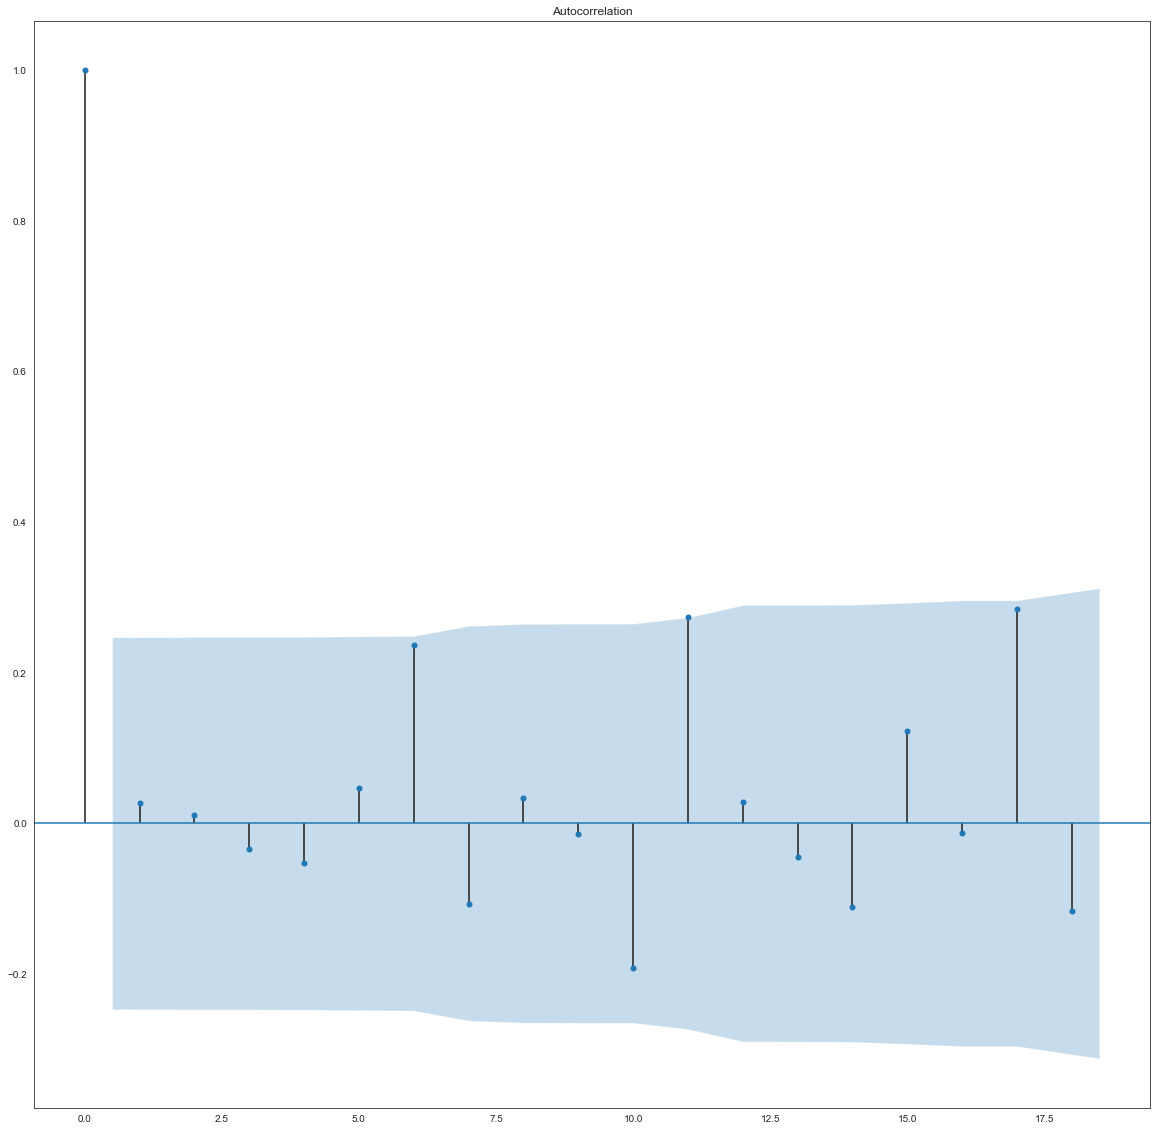

In [174]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(reg.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(reg.resid)
plt.show()

### 3)  Normally Distributed Residuals


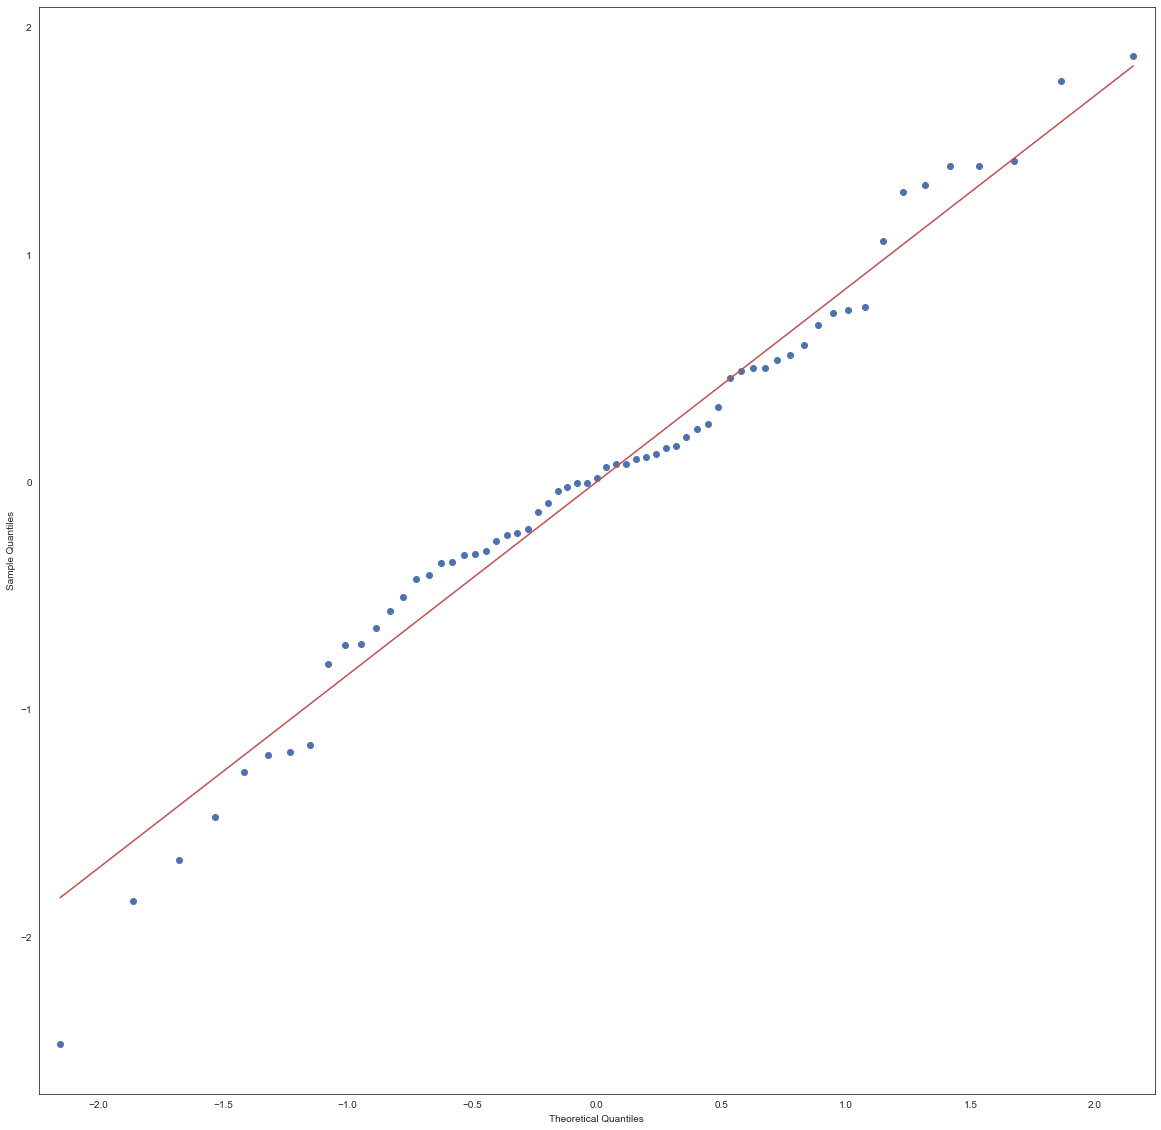

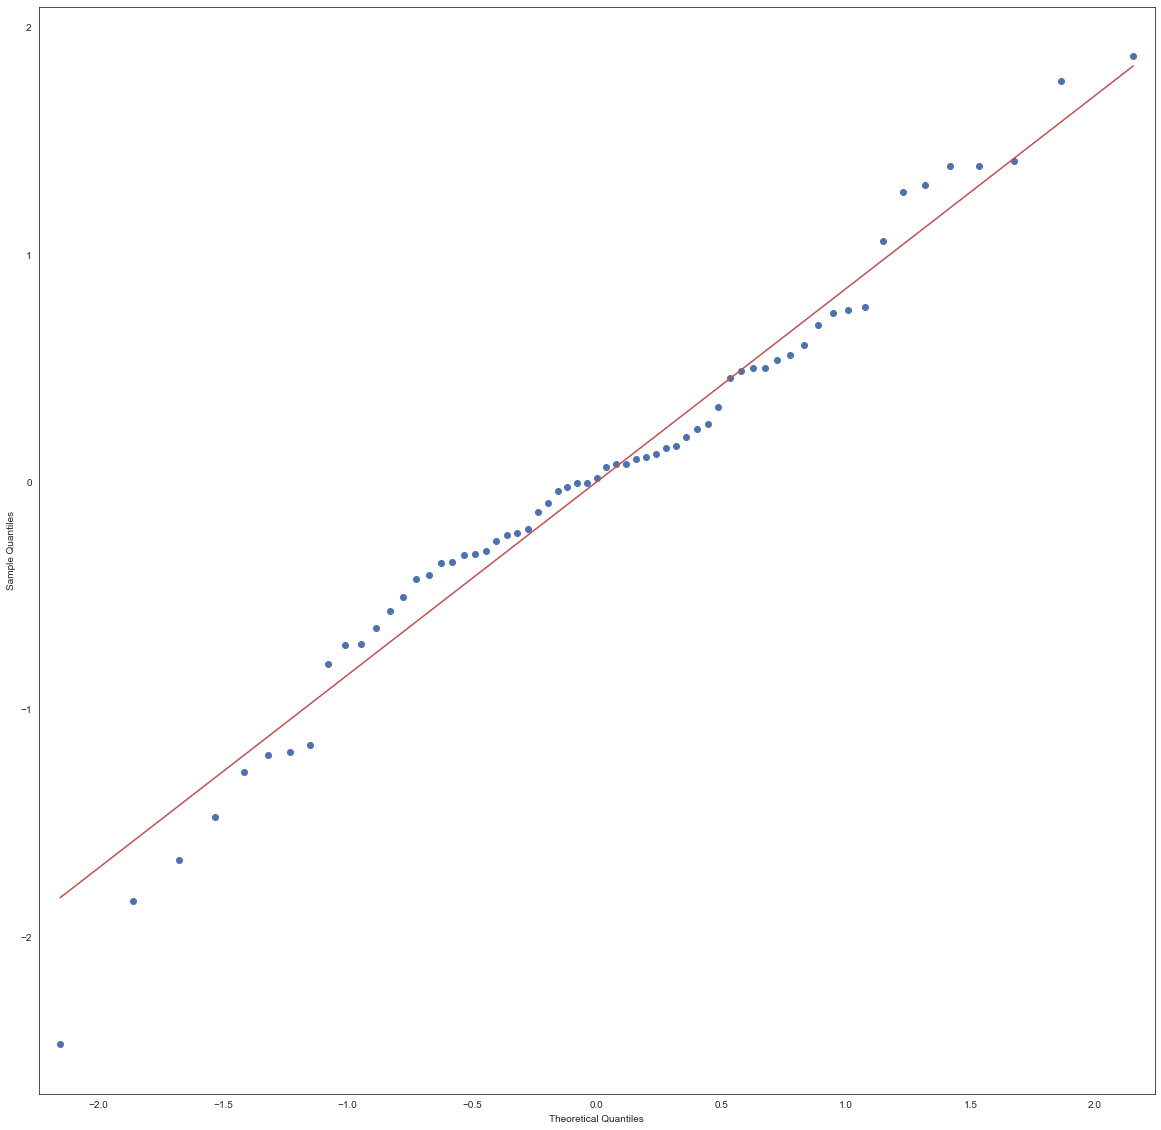

In [175]:
sm.qqplot(reg.resid, line = 's')

### 4) Mean of Residuals Equals 0

In [176]:
np.mean(reg.resid)

-1.798385074015829e-15

## Model Evaluation

Now that we've confirmed that all of the model assumptions have been met, we can now proceed in evaluating the effectiveness of the model.

In [177]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.9467
Date:                Tue, 01 Sep 2020   Prob (F-statistic):              0.532
Time:                        20:51:14   Log-Likelihood:                -79.082
No. Observations:                  63   AIC:                             196.2
Df Residuals:                      44   BIC:                             236.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.665e-16      0.128    1.3e-15      1.000      -0.258       0.258
giannis_FTA     -0.1646      0.162     -1.018      0.314      -0.491       0.161
giannis_AST      0.2855      0.177      1.614      0.114      -0.071       0.642
giannis_STL      0.0754      0.164      0.460      0.648      -0.255       0.406
giannis_BLK     -0.0421      0.162     -0.260      0.796      -0.368       0.284
giannis_PF      -0.0603      0.164     -0.368      0.715      -0.391       0.270
down_low         0.1458      0.171      0.854      0.398      -0.198       0.490
mid_range        0.0613      0.143      0.428      0.671      -0.227       0.350
three           -0.0631      0.149     -0.423      0.675      -0.364       0.238
FG3M_team       -0.2274      0.170     -1.334      0.189      -0.571       0.116
E_DEF_RATING    -0.1827      0.155     -1.177      0.246      -0.496       0.130
E_PACE          -0.0945      0.153     -0.617      0.541      -0.403       0.214
E_DREB_PCT      -0.0367      0.156     -0.235      0.815      -0.351       0.278
opp_DREB        -0.0473      0.153     -0.309      0.759      -0.355       0.261
opp_STL          0.0311      0.168      0.185      0.854      -0.308       0.370
opp_TOV         -0.1810      0.179     -1.014      0.316      -0.541       0.179
opp_PTS          0.0601      0.189      0.317      0.753      -0.322       0.442
opp_BLK         -0.3804      0.170     -2.240      0.030      -0.723      -0.038
opp_PF           0.2478      0.204      1.218      0.230      -0.162       0.658
==============================================================================
Omnibus:                        2.020   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                1.252
Skew:                          -0.260   Prob(JB):                        0.535
Kurtosis:                       3.454   Cond. No.                         3.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we have obtained $R^2 = 0.279$. This isn't too great. $R^2$ is the proportion of variance in our target feature (points) that can be explained by our features (stats). Thus, our selected features are only able to explain about 30% of the variance that exists with points.

## Next Steps

I think there were a couple things that were flawed when building our model. Firstly, I think the features being fed to the model weren't able to capture our goal. Each of the stats being used were on a *per game basis*. Although we were indeed trying to predict how many points Giannis would score in a given game, I think it would be much better if we used *play-by-play stats*. Since the points Giannis scores in a given game is just the aggregate of the number of points he scores in each play, it would be much more useful to know his environment in a given play. Who was guarding him? How far was his defender when he took the shot? What was the play type (ISO, pick-and-roll, fastbreak, etc.)? With this type of information, I think we could have been able to produce significantly better results. Unfortunately, the NBA does not release this kind of "play-by-play" data, so predicting his buckets might have to be put on hold for a little while.